# Titanic Competition - Modeling

## 5. Modeling

**Data preparation**:
* Split train dataset into training (90%) and test (validation) (10%) sets using `train_test_split`
* Define predictive variables (X) and the target variable (y = is_canceled)
* Apply `random_state=42` to ensure reproducibility

**Classification models**:
* Naive Bayes (`GaussianNB`): no hyperparameters
* K-Nearest Neighbors (`KNeighborsClassifier`): optimize `n_neighbors`
* Logistic Regression (`LogisticRegression`): optimize `C` and `max_iter`
* Linear Discriminant Analysis (`LinearDiscriminantAnalysis`): no hyperparameters
* Quadratic Discriminant Analysis (`QuadraticDiscriminantAnalysis`): no hyperparameters
* Decision Tree (`DecisionTreeClassifier`): optimize `max_depth`, `min_samples_split`, `min_samples_leaf`
* Random Forest (`RandomForestClassifier`): optimize `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
* Suppor Vector Classifier (`SVC`): optimize `C`, `degree`

**Optimization techniques**:
* Grid Search with 5-fold cross-validation (`cv=5`)
* Optimization based on F1-score (`scoring='f1'`)
* Feature selection using Forward Selection

**Evaluation metrics**:
* Accuracy – overall correctness of classification
* Precision – quality of positive predictions
* Recall – coverage of actual positive cases
* F1-score – harmonic mean of precision and recall
* ROC-AUC – class separability
* Training time and prediction time – computational efficiency

**Process automation**:
* Systematic testing of all models across all feature combinations
* Automatic saving of results to a CSV file
* Detailed logging of progress and results for each model
* Error handling and process continuation in case of failures

### 5.1 Prepare helper functions

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
from itertools import chain, combinations
from typing import List

def powerset(columns: List[str]) -> List[List[str]]:
    all_subsets = chain.from_iterable(
        combinations(columns, r) for r in range(1, len(columns) + 1)
    )
    
    valid_subsets = []
    for subset in all_subsets:
        subset = set(subset)
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "EmbarkedA" in subset and not {"EmbarkedB", "EmbarkedC"}.issubset(subset):
            continue
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "Pclass1" in subset and not {"Pclass2", "Pclass3"}.issubset(subset):
            continue
        
        valid_subsets.append(list(subset))
    
    return valid_subsets

In [3]:
models_and_params = {
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {},
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9, 12],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "penalty": ["elasticnet"],
            "C": [0.001, 0.01, 0.1, 1, 10],
            "max_iter": [100, 200, 500]
        },
    },
    "LinearDiscriminantAnalysis": {
        "model": LinearDiscriminantAnalysis(),
        "params": {},   
    },
    "QuadraticDiscriminantAnalysis": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300, 500],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "degree": [2, 3, 4],
        }
    }
}

In [4]:
from typing import Dict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import time

def evaluate_model(grid_search, X_test: pd.DataFrame, y_test: pd.DataFrame) -> Dict:
    print(f"\nEvaluating model: {grid_search.best_estimator_.__class__.__name__}")
    
    fit_times = grid_search.cv_results_['mean_fit_time']
    mean_fit_time = np.mean(fit_times)
    
    start_time = time.time()
    y_pred = grid_search.predict(X_test)
    predict_time = time.time() - start_time
    
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search, "predict_proba") else None

    metrics = {
        'accuracy': np.round(
            accuracy_score(y_test, y_pred), 4
        ),
        'precision': np.round(
            precision_score(y_test, y_pred, zero_division=0), 4
        ),
        'recall': np.round(
            recall_score(y_test, y_pred, zero_division=0), 3
        ),
        'f1': np.round(
            f1_score(y_test, y_pred, zero_division=0), 3
        ),
        'roc_auc': np.round(
            roc_auc_score(y_test, y_pred_proba), 3
        ) if y_pred_proba is not None else None,
        'mean_fit_time': np.round(
            mean_fit_time, 3
        ),
        'predict_time': np.round(
            predict_time, 3
        ),
    }
    
    print("Metrics obtained:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value}")
    
    return metrics

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import GridSearchCV

def evaluate_models(models_and_params: Dict, X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> List:
    print(f"\nStarting evaluation of {len(models_and_params)} models")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    results = []
    for name, info in models_and_params.items():
        print(f"\n{'='*50}")
        print(f"Training model: {name}")
        print(f"Parameter grid: {info['params']}")
        
        model = info["model"]
        params = info["params"]
        
        try:
            start_time = time.time()
            
            grid_search = GridSearchCV(
                estimator=model, 
                param_grid=params,
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1,
                return_train_score=True
            )
            
            grid_search.fit(X_train, y_train)
            
            metrics = evaluate_model(grid_search, X_val, y_val)
            training_time = time.time() - start_time
            
            print(f"Best parameters found: {grid_search.best_params_}")
            print(f"Training time: {training_time:.2f} seconds")
            
            result = {
                'model': name,
                'columns': X_train.columns.tolist(),
                'best_params': str(grid_search.best_params_),
                'training_time': training_time,
                **metrics
            }
            results.append(result)
            
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
    
    return results

In [6]:
def prepare_evalution(models_and_params: Dict, columns: List[str], X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> pd.DataFrame:
    results = []
    total_combinations = len(list(powerset(columns)))
    
    print(f"Starting evaluation with {len(columns)} features")
    print(f"Total feature combinations to evaluate: {total_combinations}")
    
    for i, cols in enumerate(tqdm(powerset(columns)), 1):
        
        print(f"\nEvaluating combination {i}/{total_combinations}")
        print(f"Selected features: {cols}")
        
        X_train_sub = X_train[list(cols)]
        X_val_sub = X_val[list(cols)]
        
        results.append(
            evaluate_models(models_and_params, X_train_sub, y_train, X_val_sub, y_val)
        )
        
        print(f"Completed combination {i}/{total_combinations}")
    
    print("\nCreating results DataFrame...")
    results_list = [pd.DataFrame(result) for result in results]
    results_df = pd.concat(results_list, ignore_index=True).reset_index(drop=True)
    
    print("Saving results to CSV...")
    results_df.to_csv("data/train_results.csv")
    
    print("Evaluation complete!")
    
    return results_df


### 5.2 Prepare data

In [7]:
train_clean = pd.read_csv("data/train_clean.csv")
train_clean.head()

,Survived,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,0,1,-0.532730,-0.500240,0,0,1,0,0,1
1,1,0,0.673661,0.788947,1,0,0,1,0,0
2,1,0,-0.231132,-0.486650,0,0,1,0,0,1
3,1,0,0.447463,0.422861,0,0,1,1,0,0
4,0,1,0.447463,-0.484133,0,0,1,0,0,1


In [8]:
from sklearn.model_selection import train_test_split

X = train_clean.drop(columns=["Survived"])
y = train_clean["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
columns = X.columns.to_list()
columns

['Sex',
 'Age',
 'Fare',
 'EmbarkedC',
 'EmbarkedQ',
 'EmbarkedS',
 'Pclass1',
 'Pclass2',
 'Pclass3']

### 5.3 Modeling

In [10]:
results = prepare_evalution(
    models_and_params, 
    columns, 
    X_train, 
    y_train, 
    X_val, 
    y_val
)

Starting evaluation with 9 features
Total feature combinations to evaluate: 319


  0%|          | 0/319 [00:00<?, ?it/s]


Evaluating combination 1/319
Selected features: ['Sex']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: GaussianNB
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.826
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.86 seconds

Training model: KNeighborsClassifier
Parameter grid: {'n_neighbors': [3, 5, 7, 9, 12]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.826
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 12}
Training time: 1.20 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], '

  0%|          | 1/319 [00:14<1:17:49, 14.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.826
- mean_fit_time: 0.296
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 1/319

Evaluating combination 2/319
Selected features: ['Age']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Eva

  1%|          | 2/319 [00:29<1:19:13, 14.99s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5455
- recall: 0.387
- f1: 0.453
- roc_auc: 0.595
- mean_fit_time: 0.349
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 14.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.065
- f1: 0.114
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.14 seconds
Completed combination 2/319

Evaluating combination 3/319
Selected features: ['Fare']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluatin

  1%|          | 3/319 [00:46<1:23:49, 15.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6129
- recall: 0.613
- f1: 0.613
- roc_auc: 0.699
- mean_fit_time: 0.395
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 16.62 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7143
- recall: 0.323
- f1: 0.444
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 3/319

Evaluating combination 4/319
Selected features: ['EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

  1%|▏         | 4/319 [00:59<1:16:59, 14.66s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.583
- mean_fit_time: 0.299
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 4/319

Evaluating combination 5/319
Selected features: ['EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Eva

  2%|▏         | 5/319 [01:12<1:12:57, 13.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.444
- mean_fit_time: 0.297
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 5/319

Evaluating combination 6/319
Selected features: ['EmbarkedS']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating 

  2%|▏         | 6/319 [01:25<1:10:40, 13.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.638
- mean_fit_time: 0.299
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 6/319

Evaluating combination 7/319
Selected features: ['Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating mode

  2%|▏         | 7/319 [01:37<1:08:59, 13.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.475
- mean_fit_time: 0.297
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 7/319

Evaluating combination 8/319
Selected features: ['Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 1)
Validation data shape: (89, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating mode

  3%|▎         | 8/319 [01:50<1:07:56, 13.11s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.632
- mean_fit_time: 0.298
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 8/319

Evaluating combination 9/319
Selected features: ['Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

  3%|▎         | 9/319 [02:05<1:11:19, 13.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7273
- recall: 0.774
- f1: 0.75
- roc_auc: 0.853
- mean_fit_time: 0.352
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 14.92 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.024
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.17 seconds
Completed combination 9/319

Evaluating combination 10/319
Selected features: ['Sex', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fit

  3%|▎         | 10/319 [02:21<1:14:20, 14.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.6765
- recall: 0.742
- f1: 0.708
- roc_auc: 0.847
- mean_fit_time: 0.366
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 10/319

Evaluating combination 11/319
Selected features: ['Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

  3%|▎         | 11/319 [02:34<1:11:23, 13.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.846
- mean_fit_time: 0.301
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 11/319

Evaluating combination 12/319
Selected features: ['Sex', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

  4%|▍         | 12/319 [02:47<1:09:29, 13.58s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.817
- mean_fit_time: 0.3
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 12/319

Evaluating combination 13/319
Selected features: ['EmbarkedS', 'Sex']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  4%|▍         | 13/319 [03:00<1:07:57, 13.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.855
- mean_fit_time: 0.3
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 13/319

Evaluating combination 14/319
Selected features: ['Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 

  4%|▍         | 14/319 [03:12<1:06:56, 13.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.861
- mean_fit_time: 0.302
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 14/319

Evaluating combination 15/319
Selected features: ['Pclass3', 'Sex']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  5%|▍         | 15/319 [03:25<1:06:23, 13.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.872
- mean_fit_time: 0.302
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 12.60 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8947
- recall: 0.548
- f1: 0.68
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 15/319

Evaluating combination 16/319
Selected features: ['Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 

  5%|▌         | 16/319 [03:42<1:11:08, 14.09s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.775
- mean_fit_time: 0.386
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.00 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6875
- recall: 0.355
- f1: 0.468
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 16/319

Evaluating combination 17/319
Selected features: ['Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  5%|▌         | 17/319 [03:57<1:13:04, 14.52s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6087
- recall: 0.452
- f1: 0.519
- roc_auc: 0.613
- mean_fit_time: 0.353
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.4706
- recall: 0.258
- f1: 0.333
- roc_auc: None
- mean_fit_time: 0.018
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 17/319

Evaluating combination 18/319
Selected features: ['EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

  6%|▌         | 18/319 [04:13<1:14:16, 14.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5417
- recall: 0.419
- f1: 0.473
- roc_auc: 0.632
- mean_fit_time: 0.35
- predict_time: 0.011
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 15.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.7143
- recall: 0.161
- f1: 0.263
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 18/319

Evaluating combination 19/319
Selected features: ['EmbarkedS', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  6%|▌         | 19/319 [04:28<1:15:00, 15.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6316
- recall: 0.387
- f1: 0.48
- roc_auc: 0.631
- mean_fit_time: 0.353
- predict_time: 0.005
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5294
- recall: 0.29
- f1: 0.375
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 19/319

Evaluating combination 20/319
Selected features: ['Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 f

  6%|▋         | 20/319 [04:43<1:15:14, 15.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5238
- recall: 0.355
- f1: 0.423
- roc_auc: 0.591
- mean_fit_time: 0.353
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 14.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.3333
- recall: 0.032
- f1: 0.059
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 20/319

Evaluating combination 21/319
Selected features: ['Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  7%|▋         | 21/319 [04:59<1:15:43, 15.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5312
- recall: 0.548
- f1: 0.54
- roc_auc: 0.72
- mean_fit_time: 0.351
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 15.18 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.5955
- precision: 0.4444
- recall: 0.645
- f1: 0.526
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 21/319

Evaluating combination 22/319
Selected features: ['Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 

  7%|▋         | 22/319 [05:15<1:16:41, 15.49s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.714
- mean_fit_time: 0.367
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.75
- recall: 0.29
- f1: 0.419
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 22/319

Evaluating combination 23/319
Selected features: ['EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  7%|▋         | 23/319 [05:31<1:17:20, 15.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: 0.701
- mean_fit_time: 0.37
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7143
- recall: 0.323
- f1: 0.444
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 23/319

Evaluating combination 24/319
Selected features: ['EmbarkedS', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5

  8%|▊         | 24/319 [05:47<1:17:44, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.705
- mean_fit_time: 0.367
- predict_time: 0.011
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 15.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.8182
- recall: 0.29
- f1: 0.429
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 24/319

Evaluating combination 25/319
Selected features: ['Pclass2', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  8%|▊         | 25/319 [06:03<1:17:40, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5862
- recall: 0.548
- f1: 0.567
- roc_auc: 0.694
- mean_fit_time: 0.367
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5909
- recall: 0.419
- f1: 0.491
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 25/319

Evaluating combination 26/319
Selected features: ['Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  8%|▊         | 26/319 [06:19<1:17:31, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5758
- recall: 0.613
- f1: 0.594
- roc_auc: 0.718
- mean_fit_time: 0.366
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 26/319

Evaluating combination 27/319
Selected features: ['EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

  8%|▊         | 27/319 [06:32<1:12:47, 14.96s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.629
- mean_fit_time: 0.301
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 27/319

Evaluating combination 28/319
Selected features: ['EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

  9%|▉         | 28/319 [06:45<1:09:24, 14.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.629
- mean_fit_time: 0.301
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 28/319

Evaluating combination 29/319
Selected features: ['Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  9%|▉         | 29/319 [06:58<1:07:06, 13.88s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.59
- mean_fit_time: 0.302
- predict_time: 0.002
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.52 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 29/319

Evaluating combination 30/319
Selected features: ['Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 

  9%|▉         | 30/319 [07:11<1:05:26, 13.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.662
- mean_fit_time: 0.302
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.53 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 30/319

Evaluating combination 31/319
Selected features: ['EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 10%|▉         | 31/319 [07:23<1:04:09, 13.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.629
- mean_fit_time: 0.301
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.51 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 31/319

Evaluating combination 32/319
Selected features: ['EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

 10%|█         | 32/319 [07:36<1:03:26, 13.26s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.442
- mean_fit_time: 0.303
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 12.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 32/319

Evaluating combination 33/319
Selected features: ['Pclass3', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits



 10%|█         | 33/319 [07:49<1:02:36, 13.13s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.651
- mean_fit_time: 0.302
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 33/319

Evaluating combination 34/319
Selected features: ['EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, total

 11%|█         | 34/319 [08:02<1:01:56, 13.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6404
- precision: 0.3333
- recall: 0.032
- f1: 0.059
- roc_auc: 0.572
- mean_fit_time: 0.302
- predict_time: 0.002
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.3333
- recall: 0.032
- f1: 0.059
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 34/319

Evaluating combination 35/319
Selected features: ['EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

 11%|█         | 35/319 [08:15<1:01:31, 13.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.694
- mean_fit_time: 0.302
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 35/319

Evaluating combination 36/319
Selected features: ['Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 2)
Validation data shape: (89, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

 11%|█▏        | 36/319 [08:28<1:01:05, 12.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.679
- mean_fit_time: 0.303
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6364
- recall: 0.452
- f1: 0.528
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 36/319

Evaluating combination 37/319
Selected features: ['Sex', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, total

 12%|█▏        | 37/319 [08:44<1:05:39, 13.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: 0.88
- mean_fit_time: 0.375
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 37/319

Evaluating combination 38/319
Selected features: ['Sex', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 12%|█▏        | 38/319 [09:00<1:07:35, 14.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.864
- mean_fit_time: 0.354
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.12 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.022
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.13 seconds
Completed combination 38/319

Evaluating combination 39/319
Selected features: ['Sex', 'EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 12%|█▏        | 39/319 [09:15<1:08:47, 14.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7419
- recall: 0.742
- f1: 0.742
- roc_auc: 0.862
- mean_fit_time: 0.354
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.023
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.14 seconds
Completed combination 39/319

Evaluating combination 40/319
Selected features: ['EmbarkedS', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 13%|█▎        | 40/319 [09:31<1:09:36, 14.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.865
- mean_fit_time: 0.356
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.019
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.13 seconds
Completed combination 40/319

Evaluating combination 41/319
Selected features: ['Sex', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

 13%|█▎        | 41/319 [09:46<1:09:58, 15.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7812
- recall: 0.806
- f1: 0.794
- roc_auc: 0.878
- mean_fit_time: 0.354
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.04 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 41/319

Evaluating combination 42/319
Selected features: ['Pclass3', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tota

 13%|█▎        | 42/319 [10:02<1:10:24, 15.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.896
- mean_fit_time: 0.352
- predict_time: 0.011
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7812
- recall: 0.806
- f1: 0.794
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 42/319

Evaluating combination 43/319
Selected features: ['Sex', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 13%|█▎        | 43/319 [10:17<1:10:46, 15.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.874
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.16 seconds
Completed combination 43/319

Evaluating combination 44/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 14%|█▍        | 44/319 [10:33<1:11:05, 15.51s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6667
- recall: 0.71
- f1: 0.688
- roc_auc: 0.852
- mean_fit_time: 0.366
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 44/319

Evaluating combination 45/319
Selected features: ['EmbarkedS', 'Sex', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 14%|█▍        | 45/319 [10:49<1:11:50, 15.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.697
- recall: 0.742
- f1: 0.719
- roc_auc: 0.864
- mean_fit_time: 0.379
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 45/319

Evaluating combination 46/319
Selected features: ['Sex', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tota

 14%|█▍        | 46/319 [11:06<1:12:27, 15.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.838
- mean_fit_time: 0.374
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 46/319

Evaluating combination 47/319
Selected features: ['Pclass3', 'Sex', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, total

 15%|█▍        | 47/319 [11:21<1:11:49, 15.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.861
- mean_fit_time: 0.359
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 47/319

Evaluating combination 48/319
Selected features: ['Sex', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 15%|█▌        | 48/319 [11:35<1:07:50, 15.02s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.855
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.76 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 48/319

Evaluating combination 49/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 15%|█▌        | 49/319 [11:48<1:04:53, 14.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.855
- mean_fit_time: 0.304
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.68 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 49/319

Evaluating combination 50/319
Selected features: ['Sex', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 16%|█▌        | 50/319 [12:01<1:02:56, 14.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.845
- mean_fit_time: 0.307
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 50/319

Evaluating combination 51/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 16%|█▌        | 51/319 [12:14<1:01:34, 13.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: 0.879
- mean_fit_time: 0.307
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 51/319

Evaluating combination 52/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 16%|█▋        | 52/319 [12:27<1:00:18, 13.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.855
- mean_fit_time: 0.304
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 52/319

Evaluating combination 53/319
Selected features: ['Sex', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 17%|█▋        | 53/319 [12:40<59:21, 13.39s/it]  


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.869
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.67 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 53/319

Evaluating combination 54/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 17%|█▋        | 54/319 [12:53<58:53, 13.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: 0.878
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 54/319

Evaluating combination 55/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 17%|█▋        | 55/319 [13:06<58:22, 13.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.879
- mean_fit_time: 0.307
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.78 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 55/319

Evaluating combination 56/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 18%|█▊        | 56/319 [13:19<58:02, 13.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.885
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 56/319

Evaluating combination 57/319
Selected features: ['Pclass3', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 18%|█▊        | 57/319 [13:33<57:42, 13.22s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.89
- mean_fit_time: 0.307
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8947
- recall: 0.548
- f1: 0.68
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 57/319

Evaluating combination 58/319
Selected features: ['Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 18%|█▊        | 58/319 [13:49<1:01:39, 14.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: 0.781
- mean_fit_time: 0.385
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.625
- recall: 0.323
- f1: 0.426
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 58/319

Evaluating combination 59/319
Selected features: ['EmbarkedQ', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 18%|█▊        | 59/319 [14:06<1:04:25, 14.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.784
- mean_fit_time: 0.387
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6818
- recall: 0.484
- f1: 0.566
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 59/319

Evaluating combination 60/319
Selected features: ['EmbarkedS', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 19%|█▉        | 60/319 [14:22<1:06:25, 15.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6129
- recall: 0.613
- f1: 0.613
- roc_auc: 0.794
- mean_fit_time: 0.38
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 16.21 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6667
- recall: 0.387
- f1: 0.49
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 60/319

Evaluating combination 61/319
Selected features: ['Pclass2', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

 19%|█▉        | 61/319 [14:39<1:07:36, 15.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5429
- recall: 0.613
- f1: 0.576
- roc_auc: 0.764
- mean_fit_time: 0.38
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 16.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6522
- recall: 0.484
- f1: 0.556
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 61/319

Evaluating combination 62/319
Selected features: ['Pclass3', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 19%|█▉        | 62/319 [14:55<1:08:08, 15.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5758
- recall: 0.613
- f1: 0.594
- roc_auc: 0.763
- mean_fit_time: 0.379
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.96 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 62/319

Evaluating combination 63/319
Selected features: ['EmbarkedQ', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 20%|█▉        | 63/319 [15:11<1:07:31, 15.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.657
- mean_fit_time: 0.356
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5714
- recall: 0.387
- f1: 0.462
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 63/319

Evaluating combination 64/319
Selected features: ['EmbarkedS', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 20%|██        | 64/319 [15:26<1:07:11, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6522
- recall: 0.484
- f1: 0.556
- roc_auc: 0.625
- mean_fit_time: 0.356
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5185
- recall: 0.452
- f1: 0.483
- roc_auc: None
- mean_fit_time: 0.019
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.16 seconds
Completed combination 64/319

Evaluating combination 65/319
Selected features: ['Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 20%|██        | 65/319 [15:42<1:07:00, 15.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6087
- recall: 0.452
- f1: 0.519
- roc_auc: 0.638
- mean_fit_time: 0.358
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5714
- recall: 0.387
- f1: 0.462
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.13 seconds
Completed combination 65/319

Evaluating combination 66/319
Selected features: ['Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 21%|██        | 66/319 [15:58<1:06:43, 15.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: 0.747
- mean_fit_time: 0.357
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.4889
- recall: 0.71
- f1: 0.579
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 66/319

Evaluating combination 67/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 21%|██        | 67/319 [16:14<1:06:23, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.625
- recall: 0.484
- f1: 0.545
- roc_auc: 0.641
- mean_fit_time: 0.355
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 15.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5185
- recall: 0.452
- f1: 0.483
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.16 seconds
Completed combination 67/319

Evaluating combination 68/319
Selected features: ['EmbarkedQ', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 21%|██▏       | 68/319 [16:29<1:05:33, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6471
- recall: 0.355
- f1: 0.458
- roc_auc: 0.627
- mean_fit_time: 0.353
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 14.96 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.7143
- recall: 0.161
- f1: 0.263
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 68/319

Evaluating combination 69/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 22%|██▏       | 69/319 [16:45<1:04:52, 15.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5278
- recall: 0.613
- f1: 0.567
- roc_auc: 0.747
- mean_fit_time: 0.352
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 14.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.4792
- recall: 0.742
- f1: 0.582
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 69/319

Evaluating combination 70/319
Selected features: ['EmbarkedS', 'Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 22%|██▏       | 70/319 [17:00<1:04:42, 15.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5714
- recall: 0.387
- f1: 0.462
- roc_auc: 0.618
- mean_fit_time: 0.359
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6
- recall: 0.29
- f1: 0.391
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 70/319

Evaluating combination 71/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 22%|██▏       | 71/319 [17:16<1:04:46, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6538
- recall: 0.548
- f1: 0.596
- roc_auc: 0.776
- mean_fit_time: 0.357
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.4783
- recall: 0.71
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 71/319

Evaluating combination 72/319
Selected features: ['Pclass3', 'Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 23%|██▎       | 72/319 [17:31<1:04:16, 15.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6552
- recall: 0.613
- f1: 0.633
- roc_auc: 0.758
- mean_fit_time: 0.355
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6522
- recall: 0.484
- f1: 0.556
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 72/319

Evaluating combination 73/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 23%|██▎       | 73/319 [17:47<1:04:17, 15.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.686
- mean_fit_time: 0.366
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.8182
- recall: 0.29
- f1: 0.429
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 73/319

Evaluating combination 74/319
Selected features: ['EmbarkedS', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 23%|██▎       | 74/319 [18:03<1:04:02, 15.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.69
- mean_fit_time: 0.369
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6471
- recall: 0.355
- f1: 0.458
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 74/319

Evaluating combination 75/319
Selected features: ['Pclass2', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 24%|██▎       | 75/319 [18:19<1:04:04, 15.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5172
- recall: 0.484
- f1: 0.5
- roc_auc: 0.693
- mean_fit_time: 0.367
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.56 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5556
- recall: 0.484
- f1: 0.517
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 75/319

Evaluating combination 76/319
Selected features: ['Pclass3', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 24%|██▍       | 76/319 [18:35<1:04:10, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5161
- recall: 0.516
- f1: 0.516
- roc_auc: 0.702
- mean_fit_time: 0.363
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5429
- recall: 0.613
- f1: 0.576
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 76/319

Evaluating combination 77/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 24%|██▍       | 77/319 [18:51<1:04:02, 15.88s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.686
- mean_fit_time: 0.366
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.8182
- recall: 0.29
- f1: 0.429
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 77/319

Evaluating combination 78/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 24%|██▍       | 78/319 [19:07<1:03:48, 15.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: 0.711
- mean_fit_time: 0.367
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5909
- recall: 0.419
- f1: 0.491
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 78/319

Evaluating combination 79/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 25%|██▍       | 79/319 [19:23<1:03:29, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.732
- mean_fit_time: 0.361
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 79/319

Evaluating combination 80/319
Selected features: ['EmbarkedS', 'Pclass2', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 25%|██▌       | 80/319 [19:39<1:03:28, 15.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.736
- mean_fit_time: 0.365
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.70 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 80/319

Evaluating combination 81/319
Selected features: ['EmbarkedS', 'Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 25%|██▌       | 81/319 [19:55<1:03:05, 15.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.699
- mean_fit_time: 0.362
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 81/319

Evaluating combination 82/319
Selected features: ['Pclass3', 'Pclass2', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 26%|██▌       | 82/319 [20:10<1:02:43, 15.88s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5806
- recall: 0.581
- f1: 0.581
- roc_auc: 0.698
- mean_fit_time: 0.363
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 82/319

Evaluating combination 83/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 26%|██▌       | 83/319 [20:23<58:58, 14.99s/it]  


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.629
- mean_fit_time: 0.303
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.56 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 83/319

Evaluating combination 84/319
Selected features: ['EmbarkedQ', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 26%|██▋       | 84/319 [20:36<56:30, 14.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.61
- mean_fit_time: 0.305
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 12.74 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 84/319

Evaluating combination 85/319
Selected features: ['Pclass3', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 27%|██▋       | 85/319 [20:50<54:45, 14.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.689
- mean_fit_time: 0.306
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 85/319

Evaluating combination 86/319
Selected features: ['EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 27%|██▋       | 86/319 [21:03<53:21, 13.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.618
- mean_fit_time: 0.304
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.66 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 86/319

Evaluating combination 87/319
Selected features: ['EmbarkedS', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 27%|██▋       | 87/319 [21:16<52:24, 13.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.679
- mean_fit_time: 0.304
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 12.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 87/319

Evaluating combination 88/319
Selected features: ['Pclass3', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 28%|██▊       | 88/319 [21:29<51:40, 13.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: 0.679
- mean_fit_time: 0.305
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.76 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 88/319

Evaluating combination 89/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 28%|██▊       | 89/319 [21:42<51:05, 13.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.618
- mean_fit_time: 0.305
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.74 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 89/319

Evaluating combination 90/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 28%|██▊       | 90/319 [21:55<50:41, 13.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: 0.679
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 90/319

Evaluating combination 91/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 29%|██▊       | 91/319 [22:08<50:14, 13.22s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: 0.7
- mean_fit_time: 0.304
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 12.70 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6364
- recall: 0.452
- f1: 0.528
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 91/319

Evaluating combination 92/319
Selected features: ['EmbarkedS', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 29%|██▉       | 92/319 [22:21<49:57, 13.21s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.714
- mean_fit_time: 0.306
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 92/319

Evaluating combination 93/319
Selected features: ['Pclass1', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 3)
Validation data shape: (89, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 29%|██▉       | 93/319 [22:34<49:30, 13.14s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6364
- recall: 0.452
- f1: 0.528
- roc_auc: 0.679
- mean_fit_time: 0.303
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6364
- recall: 0.452
- f1: 0.528
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 93/319

Evaluating combination 94/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 29%|██▉       | 94/319 [22:51<53:13, 14.20s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6842
- recall: 0.839
- f1: 0.754
- roc_auc: 0.876
- mean_fit_time: 0.394
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 94/319

Evaluating combination 95/319
Selected features: ['Sex', 'EmbarkedQ', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 30%|██▉       | 95/319 [23:08<55:43, 14.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: 0.877
- mean_fit_time: 0.394
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.26 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 95/319

Evaluating combination 96/319
Selected features: ['EmbarkedS', 'Sex', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 30%|███       | 96/319 [23:24<57:28, 15.46s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.882
- mean_fit_time: 0.393
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 16.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 96/319

Evaluating combination 97/319
Selected features: ['Sex', 'Age', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 30%|███       | 97/319 [23:41<58:47, 15.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.876
- mean_fit_time: 0.392
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 16.51 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 97/319

Evaluating combination 98/319
Selected features: ['Pclass3', 'Sex', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 31%|███       | 98/319 [23:58<59:11, 16.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.894
- mean_fit_time: 0.388
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 16.12 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 98/319

Evaluating combination 99/319
Selected features: ['Sex', 'EmbarkedQ', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 31%|███       | 99/319 [24:14<58:45, 16.02s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.878
- mean_fit_time: 0.362
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 99/319

Evaluating combination 100/319
Selected features: ['EmbarkedS', 'Sex', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 31%|███▏      | 100/319 [24:29<57:55, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.872
- mean_fit_time: 0.364
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.018
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 100/319

Evaluating combination 101/319
Selected features: ['Sex', 'Age', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 32%|███▏      | 101/319 [24:45<57:34, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7742
- recall: 0.774
- f1: 0.774
- roc_auc: 0.878
- mean_fit_time: 0.363
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 101/319

Evaluating combination 102/319
Selected features: ['Pclass3', 'Sex', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 32%|███▏      | 102/319 [25:01<57:10, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8276
- recall: 0.774
- f1: 0.8
- roc_auc: 0.913
- mean_fit_time: 0.36
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 102/319

Evaluating combination 103/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 32%|███▏      | 103/319 [25:16<56:50, 15.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.872
- mean_fit_time: 0.36
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.018
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 103/319

Evaluating combination 104/319
Selected features: ['Sex', 'EmbarkedQ', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 33%|███▎      | 104/319 [25:32<56:40, 15.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7419
- recall: 0.742
- f1: 0.742
- roc_auc: 0.889
- mean_fit_time: 0.359
- predict_time: 0.011
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 104/319

Evaluating combination 105/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 33%|███▎      | 105/319 [25:48<55:50, 15.66s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.886
- mean_fit_time: 0.355
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 14.90 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8696
- recall: 0.645
- f1: 0.741
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 105/319

Evaluating combination 106/319
Selected features: ['EmbarkedS', 'Sex', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 33%|███▎      | 106/319 [26:03<55:41, 15.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.888
- mean_fit_time: 0.362
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 106/319

Evaluating combination 107/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 34%|███▎      | 107/319 [26:19<55:22, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7857
- recall: 0.71
- f1: 0.746
- roc_auc: 0.907
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 107/319

Evaluating combination 108/319
Selected features: ['Pclass3', 'Sex', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 34%|███▍      | 108/319 [26:35<55:00, 15.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.917
- mean_fit_time: 0.356
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 15.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 108/319

Evaluating combination 109/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 34%|███▍      | 109/319 [26:50<54:54, 15.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.6765
- recall: 0.742
- f1: 0.708
- roc_auc: 0.855
- mean_fit_time: 0.368
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 109/319

Evaluating combination 110/319
Selected features: ['EmbarkedS', 'Sex', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 34%|███▍      | 110/319 [27:06<54:56, 15.77s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6571
- recall: 0.742
- f1: 0.697
- roc_auc: 0.842
- mean_fit_time: 0.368
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 110/319

Evaluating combination 111/319
Selected features: ['Sex', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 35%|███▍      | 111/319 [27:22<54:57, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.6667
- recall: 0.774
- f1: 0.716
- roc_auc: 0.845
- mean_fit_time: 0.365
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.66 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 111/319

Evaluating combination 112/319
Selected features: ['Pclass3', 'Sex', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 35%|███▌      | 112/319 [27:38<54:36, 15.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.865
- mean_fit_time: 0.364
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 112/319

Evaluating combination 113/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 35%|███▌      | 113/319 [27:54<54:35, 15.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.867
- mean_fit_time: 0.367
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 113/319

Evaluating combination 114/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 36%|███▌      | 114/319 [28:10<54:16, 15.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.6765
- recall: 0.742
- f1: 0.708
- roc_auc: 0.845
- mean_fit_time: 0.366
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 114/319

Evaluating combination 115/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 36%|███▌      | 115/319 [28:26<53:57, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.859
- mean_fit_time: 0.364
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 115/319

Evaluating combination 116/319
Selected features: ['EmbarkedS', 'Sex', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 36%|███▋      | 116/319 [28:42<53:49, 15.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7059
- recall: 0.774
- f1: 0.738
- roc_auc: 0.838
- mean_fit_time: 0.365
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.62 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 116/319

Evaluating combination 117/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 37%|███▋      | 117/319 [28:58<53:40, 15.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.866
- mean_fit_time: 0.364
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 117/319

Evaluating combination 118/319
Selected features: ['Pclass3', 'Sex', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 37%|███▋      | 118/319 [29:14<53:25, 15.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7027
- recall: 0.839
- f1: 0.765
- roc_auc: 0.855
- mean_fit_time: 0.364
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.59 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 118/319

Evaluating combination 119/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 37%|███▋      | 119/319 [29:27<50:23, 15.12s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.855
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 119/319

Evaluating combination 120/319
Selected features: ['Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 38%|███▊      | 120/319 [29:40<48:20, 14.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.88
- mean_fit_time: 0.31
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 120/319

Evaluating combination 121/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 38%|███▊      | 121/319 [29:54<46:55, 14.22s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.883
- mean_fit_time: 0.312
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 121/319

Evaluating combination 122/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 38%|███▊      | 122/319 [30:07<45:52, 13.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.88
- mean_fit_time: 0.311
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 122/319

Evaluating combination 123/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 39%|███▊      | 123/319 [30:21<45:10, 13.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.883
- mean_fit_time: 0.312
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 123/319

Evaluating combination 124/319
Selected features: ['Pclass3', 'Sex', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 39%|███▉      | 124/319 [30:34<44:27, 13.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: 0.885
- mean_fit_time: 0.31
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 124/319

Evaluating combination 125/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 39%|███▉      | 125/319 [30:47<43:54, 13.58s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.88
- mean_fit_time: 0.31
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.99 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 125/319

Evaluating combination 126/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedQ', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 39%|███▉      | 126/319 [31:01<43:35, 13.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.88
- mean_fit_time: 0.311
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 126/319

Evaluating combination 127/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 40%|███▉      | 127/319 [31:14<43:02, 13.45s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: 0.896
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 127/319

Evaluating combination 128/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 40%|████      | 128/319 [31:27<42:47, 13.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.89
- mean_fit_time: 0.312
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 128/319

Evaluating combination 129/319
Selected features: ['Pclass1', 'Sex', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 40%|████      | 129/319 [31:41<42:22, 13.38s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8947
- recall: 0.548
- f1: 0.68
- roc_auc: 0.89
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8947
- recall: 0.548
- f1: 0.68
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 129/319

Evaluating combination 130/319
Selected features: ['EmbarkedQ', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 41%|████      | 130/319 [31:58<45:43, 14.52s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5806
- recall: 0.581
- f1: 0.581
- roc_auc: 0.777
- mean_fit_time: 0.4
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 16.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.7
- recall: 0.452
- f1: 0.549
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 130/319

Evaluating combination 131/319
Selected features: ['EmbarkedS', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 41%|████      | 131/319 [32:15<47:44, 15.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5938
- recall: 0.613
- f1: 0.603
- roc_auc: 0.789
- mean_fit_time: 0.4
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.52 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6875
- recall: 0.355
- f1: 0.468
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 131/319

Evaluating combination 132/319
Selected features: ['Pclass2', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 41%|████▏     | 132/319 [32:32<49:00, 15.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5714
- recall: 0.645
- f1: 0.606
- roc_auc: 0.78
- mean_fit_time: 0.398
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6087
- recall: 0.452
- f1: 0.519
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 132/319

Evaluating combination 133/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 42%|████▏     | 133/319 [32:48<49:46, 16.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5429
- recall: 0.613
- f1: 0.576
- roc_auc: 0.761
- mean_fit_time: 0.396
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 16.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6207
- recall: 0.581
- f1: 0.6
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 133/319

Evaluating combination 134/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 42%|████▏     | 134/319 [33:06<50:36, 16.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5938
- recall: 0.613
- f1: 0.603
- roc_auc: 0.788
- mean_fit_time: 0.4
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 16.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.7
- recall: 0.452
- f1: 0.549
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 134/319

Evaluating combination 135/319
Selected features: ['EmbarkedQ', 'Age', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 42%|████▏     | 135/319 [33:23<50:46, 16.56s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6176
- recall: 0.677
- f1: 0.646
- roc_auc: 0.778
- mean_fit_time: 0.398
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.7037
- recall: 0.613
- f1: 0.655
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 135/319

Evaluating combination 136/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

 43%|████▎     | 136/319 [33:39<50:39, 16.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6061
- recall: 0.645
- f1: 0.625
- roc_auc: 0.793
- mean_fit_time: 0.388
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6316
- recall: 0.774
- f1: 0.696
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 136/319

Evaluating combination 137/319
Selected features: ['EmbarkedS', 'Pclass2', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 43%|████▎     | 137/319 [33:56<50:45, 16.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: 0.791
- mean_fit_time: 0.396
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 16.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.7368
- recall: 0.452
- f1: 0.56
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 137/319

Evaluating combination 138/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

 43%|████▎     | 138/319 [34:13<50:34, 16.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6216
- recall: 0.742
- f1: 0.676
- roc_auc: 0.789
- mean_fit_time: 0.396
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 16.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6296
- recall: 0.548
- f1: 0.586
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 138/319

Evaluating combination 139/319
Selected features: ['Pclass3', 'Pclass2', 'Age', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 44%|████▎     | 139/319 [34:30<50:21, 16.78s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: 0.763
- mean_fit_time: 0.395
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 16.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 139/319

Evaluating combination 140/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 44%|████▍     | 140/319 [34:46<49:15, 16.51s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.651
- mean_fit_time: 0.36
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5357
- recall: 0.484
- f1: 0.508
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 140/319

Evaluating combination 141/319
Selected features: ['EmbarkedQ', 'Age', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

 44%|████▍     | 141/319 [35:02<48:14, 16.26s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5909
- recall: 0.419
- f1: 0.491
- roc_auc: 0.629
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.64
- recall: 0.516
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 141/319

Evaluating combination 142/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 45%|████▍     | 142/319 [35:17<47:21, 16.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5135
- recall: 0.613
- f1: 0.559
- roc_auc: 0.733
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.15 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5319
- recall: 0.806
- f1: 0.641
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 142/319

Evaluating combination 143/319
Selected features: ['EmbarkedS', 'Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 45%|████▍     | 143/319 [35:33<46:46, 15.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5769
- recall: 0.484
- f1: 0.526
- roc_auc: 0.674
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.64
- recall: 0.516
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 143/319

Evaluating combination 144/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 45%|████▌     | 144/319 [35:49<46:16, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5714
- recall: 0.516
- f1: 0.542
- roc_auc: 0.765
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5319
- recall: 0.806
- f1: 0.641
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 144/319

Evaluating combination 145/319
Selected features: ['Pclass3', 'Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 45%|████▌     | 145/319 [36:04<45:59, 15.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.777
- mean_fit_time: 0.362
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.68
- recall: 0.548
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 145/319

Evaluating combination 146/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 46%|████▌     | 146/319 [36:20<45:39, 15.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5909
- recall: 0.419
- f1: 0.491
- roc_auc: 0.622
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.64
- recall: 0.516
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 146/319

Evaluating combination 147/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 46%|████▌     | 147/319 [36:36<45:09, 15.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5676
- recall: 0.677
- f1: 0.618
- roc_auc: 0.776
- mean_fit_time: 0.363
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.16 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5319
- recall: 0.806
- f1: 0.641
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 147/319

Evaluating combination 148/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 46%|████▋     | 148/319 [36:51<44:38, 15.66s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6667
- recall: 0.581
- f1: 0.621
- roc_auc: 0.786
- mean_fit_time: 0.357
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6667
- recall: 0.581
- f1: 0.621
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 148/319

Evaluating combination 149/319
Selected features: ['EmbarkedS', 'Pclass2', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 47%|████▋     | 149/319 [37:07<44:29, 15.70s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6774
- recall: 0.677
- f1: 0.677
- roc_auc: 0.79
- mean_fit_time: 0.363
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6923
- recall: 0.581
- f1: 0.632
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 149/319

Evaluating combination 150/319
Selected features: ['Pclass1', 'Pclass2', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 47%|████▋     | 150/319 [37:23<44:14, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6667
- recall: 0.645
- f1: 0.656
- roc_auc: 0.774
- mean_fit_time: 0.36
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6522
- recall: 0.484
- f1: 0.556
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 150/319

Evaluating combination 151/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6404
- precision: 0.4865
- recall: 0.581
- f1: 0.529
- roc_auc: 0.667
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 5}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 47%|████▋     | 151/319 [37:39<44:12, 15.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: 0.691
- mean_fit_time: 0.37
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6471
- recall: 0.355
- f1: 0.458
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 151/319

Evaluating combination 152/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 48%|████▊     | 152/319 [37:55<44:00, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5152
- recall: 0.548
- f1: 0.531
- roc_auc: 0.707
- mean_fit_time: 0.367
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5556
- recall: 0.484
- f1: 0.517
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 152/319

Evaluating combination 153/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 48%|████▊     | 153/319 [38:10<43:50, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.702
- mean_fit_time: 0.365
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 153/319

Evaluating combination 154/319
Selected features: ['EmbarkedS', 'Pclass2', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 48%|████▊     | 154/319 [38:26<43:38, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.713
- mean_fit_time: 0.367
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5556
- recall: 0.484
- f1: 0.517
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 154/319

Evaluating combination 155/319
Selected features: ['EmbarkedS', 'Pclass3', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 49%|████▊     | 155/319 [38:42<43:26, 15.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.696
- mean_fit_time: 0.364
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 155/319

Evaluating combination 156/319
Selected features: ['Pclass3', 'Pclass2', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 49%|████▉     | 156/319 [38:58<43:19, 15.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.7
- mean_fit_time: 0.366
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 156/319

Evaluating combination 157/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 49%|████▉     | 157/319 [39:14<43:02, 15.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5806
- recall: 0.581
- f1: 0.581
- roc_auc: 0.736
- mean_fit_time: 0.367
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.53 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5556
- recall: 0.484
- f1: 0.517
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 157/319

Evaluating combination 158/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 50%|████▉     | 158/319 [39:30<42:52, 15.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.72
- mean_fit_time: 0.366
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 158/319

Evaluating combination 159/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 50%|████▉     | 159/319 [39:46<42:30, 15.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5758
- recall: 0.613
- f1: 0.594
- roc_auc: 0.71
- mean_fit_time: 0.364
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 159/319

Evaluating combination 160/319
Selected features: ['EmbarkedS', 'Pclass2', 'Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 50%|█████     | 160/319 [40:02<42:29, 16.03s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.737
- mean_fit_time: 0.367
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 160/319

Evaluating combination 161/319
Selected features: ['Pclass1', 'Pclass2', 'Pclass3', 'Fare']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.581
- f1: 0.537
- roc_auc: 0.695
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 5}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
  

 50%|█████     | 161/319 [40:19<42:14, 16.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.7
- mean_fit_time: 0.369
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 161/319

Evaluating combination 162/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 51%|█████     | 162/319 [40:32<39:48, 15.21s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: 0.61
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 12.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5
- recall: 0.355
- f1: 0.415
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 162/319

Evaluating combination 163/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 51%|█████     | 163/319 [40:45<38:03, 14.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.618
- precision: 0.4667
- recall: 0.677
- f1: 0.553
- roc_auc: 0.679
- mean_fit_time: 0.309
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 12.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 163/319

Evaluating combination 164/319
Selected features: ['Pclass3', 'EmbarkedQ', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 51%|█████▏    | 164/319 [40:58<36:48, 14.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: 0.702
- mean_fit_time: 0.309
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.96 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 164/319

Evaluating combination 165/319
Selected features: ['EmbarkedS', 'Pclass2', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 52%|█████▏    | 165/319 [41:12<35:53, 13.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.704
- mean_fit_time: 0.31
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 12.99 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 165/319

Evaluating combination 166/319
Selected features: ['Pclass1', 'Pclass2', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 52%|█████▏    | 166/319 [41:25<35:06, 13.77s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: 0.679
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 166/319

Evaluating combination 167/319
Selected features: ['EmbarkedS', 'EmbarkedQ', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 52%|█████▏    | 167/319 [41:38<34:24, 13.58s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.71
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 167/319

Evaluating combination 168/319
Selected features: ['Pclass1', 'EmbarkedQ', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 53%|█████▎    | 168/319 [41:51<33:54, 13.47s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: 0.7
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6364
- recall: 0.452
- f1: 0.528
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 168/319

Evaluating combination 169/319
Selected features: ['EmbarkedS', 'Pclass2', 'Pclass3', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (800, 4)
Validation data shape: (89, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 53%|█████▎    | 169/319 [42:05<33:30, 13.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.711
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 169/319

Evaluating combination 170/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 53%|█████▎    | 170/319 [42:21<35:29, 14.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: 0.877
- mean_fit_time: 0.386
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.96 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 170/319

Evaluating combination 171/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 54%|█████▎    | 171/319 [42:38<36:57, 14.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.882
- mean_fit_time: 0.387
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 16.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 171/319

Evaluating combination 172/319
Selected features: ['Sex', 'Age', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 54%|█████▍    | 172/319 [42:54<37:46, 15.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7105
- recall: 0.871
- f1: 0.783
- roc_auc: 0.908
- mean_fit_time: 0.384
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 16.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 172/319

Evaluating combination 173/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 54%|█████▍    | 173/319 [43:10<38:09, 15.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7027
- recall: 0.839
- f1: 0.765
- roc_auc: 0.889
- mean_fit_time: 0.383
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 173/319

Evaluating combination 174/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 55%|█████▍    | 174/319 [43:27<38:37, 15.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7273
- recall: 0.774
- f1: 0.75
- roc_auc: 0.874
- mean_fit_time: 0.386
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.26 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 174/319

Evaluating combination 175/319
Selected features: ['Sex', 'Pclass2', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 55%|█████▍    | 175/319 [43:43<38:38, 16.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7419
- recall: 0.742
- f1: 0.742
- roc_auc: 0.889
- mean_fit_time: 0.385
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 175/319

Evaluating combination 176/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 55%|█████▌    | 176/319 [44:00<38:30, 16.16s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8
- recall: 0.774
- f1: 0.787
- roc_auc: 0.906
- mean_fit_time: 0.382
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 176/319

Evaluating combination 177/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 55%|█████▌    | 177/319 [44:16<38:33, 16.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7297
- recall: 0.871
- f1: 0.794
- roc_auc: 0.885
- mean_fit_time: 0.384
- predict_time: 0.013
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 16.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 177/319

Evaluating combination 178/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 56%|█████▌    | 178/319 [44:33<38:24, 16.35s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.898
- mean_fit_time: 0.381
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 178/319

Evaluating combination 179/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 56%|█████▌    | 179/319 [44:49<38:10, 16.36s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7027
- recall: 0.839
- f1: 0.765
- roc_auc: 0.902
- mean_fit_time: 0.38
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.99 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8764
- precision: 0.7941
- recall: 0.871
- f1: 0.831
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 179/319

Evaluating combination 180/319
Selected features: ['Sex', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 56%|█████▋    | 180/319 [45:05<37:30, 16.19s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7097
- recall: 0.71
- f1: 0.71
- roc_auc: 0.869
- mean_fit_time: 0.361
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 15.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 180/319

Evaluating combination 181/319
Selected features: ['Sex', 'Pclass2', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 57%|█████▋    | 181/319 [45:21<37:02, 16.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7742
- recall: 0.774
- f1: 0.774
- roc_auc: 0.885
- mean_fit_time: 0.359
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 181/319

Evaluating combination 182/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 57%|█████▋    | 182/319 [45:36<36:22, 15.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8
- recall: 0.774
- f1: 0.787
- roc_auc: 0.918
- mean_fit_time: 0.355
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 182/319

Evaluating combination 183/319
Selected features: ['Sex', 'Age', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 57%|█████▋    | 183/319 [45:52<36:02, 15.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.882
- mean_fit_time: 0.36
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 15.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 183/319

Evaluating combination 184/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 58%|█████▊    | 184/319 [46:08<35:45, 15.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.924
- mean_fit_time: 0.357
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 184/319

Evaluating combination 185/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 58%|█████▊    | 185/319 [46:24<35:18, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.7714
- recall: 0.871
- f1: 0.818
- roc_auc: 0.928
- mean_fit_time: 0.355
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 185/319

Evaluating combination 186/319
Selected features: ['Sex', 'Pclass2', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 58%|█████▊    | 186/319 [46:39<34:52, 15.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.889
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.15 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 186/319

Evaluating combination 187/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 59%|█████▊    | 187/319 [46:55<34:30, 15.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8764
- precision: 0.8571
- recall: 0.774
- f1: 0.814
- roc_auc: 0.919
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 187/319

Evaluating combination 188/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 59%|█████▉    | 188/319 [47:10<34:09, 15.65s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8764
- precision: 0.8571
- recall: 0.774
- f1: 0.814
- roc_auc: 0.943
- mean_fit_time: 0.355
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.12 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8696
- recall: 0.645
- f1: 0.741
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 188/319

Evaluating combination 189/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 59%|█████▉    | 189/319 [47:26<34:02, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8764
- precision: 0.8333
- recall: 0.806
- f1: 0.82
- roc_auc: 0.928
- mean_fit_time: 0.357
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 189/319

Evaluating combination 190/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.6765
- recall: 0.742
- f1: 0.708
- roc_auc: 0.902
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 5}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 60%|█████▉    | 190/319 [47:42<33:36, 15.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.923
- mean_fit_time: 0.355
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7812
- recall: 0.806
- f1: 0.794
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 190/319

Evaluating combination 191/319
Selected features: ['Sex', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 60%|█████▉    | 191/319 [47:58<33:30, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6571
- recall: 0.742
- f1: 0.697
- roc_auc: 0.857
- mean_fit_time: 0.365
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 191/319

Evaluating combination 192/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 60%|██████    | 192/319 [48:13<33:15, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.846
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 192/319

Evaluating combination 193/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 61%|██████    | 193/319 [48:29<32:57, 15.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7027
- recall: 0.839
- f1: 0.765
- roc_auc: 0.855
- mean_fit_time: 0.359
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 193/319

Evaluating combination 194/319
Selected features: ['Sex', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 61%|██████    | 194/319 [48:45<32:43, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7059
- recall: 0.774
- f1: 0.738
- roc_auc: 0.846
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 194/319

Evaluating combination 195/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 61%|██████    | 195/319 [49:00<32:22, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.854
- mean_fit_time: 0.359
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.15 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 195/319

Evaluating combination 196/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 61%|██████▏   | 196/319 [49:16<32:17, 15.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6757
- recall: 0.806
- f1: 0.735
- roc_auc: 0.849
- mean_fit_time: 0.362
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 196/319

Evaluating combination 197/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 62%|██████▏   | 197/319 [49:32<32:01, 15.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.844
- mean_fit_time: 0.363
- predict_time: 0.005
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 197/319

Evaluating combination 198/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 62%|██████▏   | 198/319 [49:48<31:42, 15.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.846
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.24 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 198/319

Evaluating combination 199/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 62%|██████▏   | 199/319 [50:04<31:32, 15.77s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.854
- mean_fit_time: 0.359
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 199/319

Evaluating combination 200/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 63%|██████▎   | 200/319 [50:19<31:18, 15.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.848
- mean_fit_time: 0.36
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 200/319

Evaluating combination 201/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 63%|██████▎   | 201/319 [50:35<31:04, 15.80s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.853
- mean_fit_time: 0.364
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 201/319

Evaluating combination 202/319
Selected features: ['Sex', 'Pclass2', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 63%|██████▎   | 202/319 [50:49<29:26, 15.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.88
- mean_fit_time: 0.311
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 202/319

Evaluating combination 203/319
Selected features: ['Sex', 'Pclass3', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 64%|██████▎   | 203/319 [51:02<28:14, 14.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.888
- mean_fit_time: 0.312
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.04 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 203/319

Evaluating combination 204/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 64%|██████▍   | 204/319 [51:16<27:20, 14.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.313
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.11 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 204/319

Evaluating combination 205/319
Selected features: ['Sex', 'Pclass3', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 64%|██████▍   | 205/319 [51:29<26:42, 14.06s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.313
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 205/319

Evaluating combination 206/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 65%|██████▍   | 206/319 [51:43<26:11, 13.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: 0.885
- mean_fit_time: 0.313
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.16 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8261
- recall: 0.613
- f1: 0.704
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 206/319

Evaluating combination 207/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

 65%|██████▍   | 207/319 [51:56<25:48, 13.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.314
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.26 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 207/319

Evaluating combination 208/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 65%|██████▌   | 208/319 [52:10<25:23, 13.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: 0.896
- mean_fit_time: 0.311
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.9091
- recall: 0.645
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 208/319

Evaluating combination 209/319
Selected features: ['Sex', 'Pclass3', 'Pclass1', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 66%|██████▌   | 209/319 [52:23<25:04, 13.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.89
- mean_fit_time: 0.312
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.15 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 209/319

Evaluating combination 210/319
Selected features: ['Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 66%|██████▌   | 210/319 [52:40<26:39, 14.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: 0.783
- mean_fit_time: 0.393
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 16.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.7
- recall: 0.452
- f1: 0.549
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 210/319

Evaluating combination 211/319
Selected features: ['Pclass2', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 66%|██████▌   | 211/319 [52:57<27:24, 15.23s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5714
- recall: 0.645
- f1: 0.606
- roc_auc: 0.794
- mean_fit_time: 0.389
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.11 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6667
- recall: 0.581
- f1: 0.621
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 211/319

Evaluating combination 212/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 66%|██████▋   | 212/319 [53:13<27:50, 15.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6
- recall: 0.677
- f1: 0.636
- roc_auc: 0.789
- mean_fit_time: 0.387
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6562
- recall: 0.677
- f1: 0.667
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 212/319

Evaluating combination 213/319
Selected features: ['Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 67%|██████▋   | 213/319 [53:30<28:09, 15.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: 0.787
- mean_fit_time: 0.39
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 16.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.7273
- recall: 0.516
- f1: 0.604
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 213/319

Evaluating combination 214/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 67%|██████▋   | 214/319 [53:47<28:11, 16.11s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.5946
- recall: 0.71
- f1: 0.647
- roc_auc: 0.786
- mean_fit_time: 0.386
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 16.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6562
- recall: 0.677
- f1: 0.667
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 214/319

Evaluating combination 215/319
Selected features: ['Pclass3', 'Age', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 67%|██████▋   | 215/319 [54:03<28:13, 16.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6
- recall: 0.677
- f1: 0.636
- roc_auc: 0.784
- mean_fit_time: 0.388
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 16.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6296
- recall: 0.548
- f1: 0.586
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 215/319

Evaluating combination 216/319
Selected features: ['Pclass2', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 68%|██████▊   | 216/319 [54:20<28:03, 16.35s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: 0.789
- mean_fit_time: 0.389
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7727
- recall: 0.548
- f1: 0.642
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 216/319

Evaluating combination 217/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 68%|██████▊   | 217/319 [54:36<27:51, 16.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5405
- recall: 0.645
- f1: 0.588
- roc_auc: 0.782
- mean_fit_time: 0.387
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6774
- recall: 0.677
- f1: 0.677
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 217/319

Evaluating combination 218/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 68%|██████▊   | 218/319 [54:53<27:36, 16.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6286
- recall: 0.71
- f1: 0.667
- roc_auc: 0.788
- mean_fit_time: 0.386
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6471
- recall: 0.71
- f1: 0.677
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 218/319

Evaluating combination 219/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 69%|██████▊   | 219/319 [55:09<27:23, 16.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6286
- recall: 0.71
- f1: 0.667
- roc_auc: 0.81
- mean_fit_time: 0.388
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.72
- recall: 0.581
- f1: 0.643
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 219/319

Evaluating combination 220/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 69%|██████▉   | 220/319 [55:26<27:13, 16.50s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5833
- recall: 0.677
- f1: 0.627
- roc_auc: 0.77
- mean_fit_time: 0.392
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 220/319

Evaluating combination 221/319
Selected features: ['Pclass2', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 69%|██████▉   | 221/319 [55:42<26:37, 16.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.56
- recall: 0.452
- f1: 0.5
- roc_auc: 0.701
- mean_fit_time: 0.363
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.64
- recall: 0.516
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 221/319

Evaluating combination 222/319
Selected features: ['Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5641
- recall: 0.71
- f1: 0.629
- roc_auc: 0.762
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score


 70%|██████▉   | 222/319 [55:58<26:08, 16.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6
- recall: 0.581
- f1: 0.59
- roc_auc: 0.751
- mean_fit_time: 0.361
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5319
- recall: 0.806
- f1: 0.641
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 222/319

Evaluating combination 223/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

 70%|██████▉   | 223/319 [56:13<25:35, 16.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6897
- recall: 0.645
- f1: 0.667
- roc_auc: 0.779
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.18 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 223/319

Evaluating combination 224/319
Selected features: ['Pclass3', 'Age', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 70%|███████   | 224/319 [56:29<25:16, 15.96s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6897
- recall: 0.645
- f1: 0.667
- roc_auc: 0.796
- mean_fit_time: 0.361
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 224/319

Evaluating combination 225/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6389
- recall: 0.742
- f1: 0.687
- roc_auc: 0.81
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
 

 71%|███████   | 225/319 [56:45<24:59, 15.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6452
- recall: 0.645
- f1: 0.645
- roc_auc: 0.784
- mean_fit_time: 0.362
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 15.51 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.68
- recall: 0.548
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 225/319

Evaluating combination 226/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 71%|███████   | 226/319 [57:01<24:34, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.789
- mean_fit_time: 0.359
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 226/319

Evaluating combination 227/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 71%|███████   | 227/319 [57:16<24:07, 15.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6923
- recall: 0.581
- f1: 0.632
- roc_auc: 0.781
- mean_fit_time: 0.355
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.04 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6667
- recall: 0.581
- f1: 0.621
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 227/319

Evaluating combination 228/319
Selected features: ['Pclass3', 'Pclass1', 'Age', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7079
- precision: 0.5806
- recall: 0.581
- f1: 0.581
- roc_auc: 0.734
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **f

 71%|███████▏  | 228/319 [57:32<23:48, 15.70s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6452
- recall: 0.645
- f1: 0.645
- roc_auc: 0.78
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.764
- precision: 0.6923
- recall: 0.581
- f1: 0.632
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 228/319

Evaluating combination 229/319
Selected features: ['Pclass2', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 72%|███████▏  | 229/319 [57:48<23:42, 15.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.714
- mean_fit_time: 0.368
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5556
- recall: 0.484
- f1: 0.517
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 229/319

Evaluating combination 230/319
Selected features: ['Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 72%|███████▏  | 230/319 [58:04<23:25, 15.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5312
- recall: 0.548
- f1: 0.54
- roc_auc: 0.732
- mean_fit_time: 0.362
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 230/319

Evaluating combination 231/319
Selected features: ['Pclass2', 'Pclass3', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 72%|███████▏  | 231/319 [58:19<23:07, 15.77s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.722
- mean_fit_time: 0.361
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 231/319

Evaluating combination 232/319
Selected features: ['Pclass3', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 73%|███████▎  | 232/319 [58:35<22:53, 15.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.721
- mean_fit_time: 0.361
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 232/319

Evaluating combination 233/319
Selected features: ['Pclass1', 'Pclass3', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 73%|███████▎  | 233/319 [58:51<22:43, 15.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.697
- mean_fit_time: 0.364
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.61 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 233/319

Evaluating combination 234/319
Selected features: ['Pclass2', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 73%|███████▎  | 234/319 [59:07<22:25, 15.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.73
- mean_fit_time: 0.361
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.32 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 234/319

Evaluating combination 235/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.5618
- precision: 0.4091
- recall: 0.581
- f1: 0.48
- roc_auc: 0.632
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score


 74%|███████▎  | 235/319 [59:23<22:05, 15.78s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.716
- mean_fit_time: 0.363
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 235/319

Evaluating combination 236/319
Selected features: ['Pclass3', 'Pclass1', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 74%|███████▍  | 236/319 [59:38<21:51, 15.80s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.73
- mean_fit_time: 0.363
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 236/319

Evaluating combination 237/319
Selected features: ['Pclass2', 'Pclass3', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

 74%|███████▍  | 237/319 [59:52<20:36, 15.08s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.704
- mean_fit_time: 0.309
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 237/319

Evaluating combination 238/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 75%|███████▍  | 238/319 [1:00:05<19:36, 14.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: 0.702
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 238/319

Evaluating combination 239/319
Selected features: ['Pclass3', 'Pclass1', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 75%|███████▍  | 239/319 [1:00:18<18:53, 14.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.71
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 12.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 239/319

Evaluating combination 240/319
Selected features: ['Pclass2', 'Pclass3', 'Pclass1', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 5)
Validation data shape: (89, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 75%|███████▌  | 240/319 [1:00:32<18:20, 13.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.71
- mean_fit_time: 0.308
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 12.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 240/319

Evaluating combination 241/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 76%|███████▌  | 241/319 [1:00:48<19:07, 14.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7273
- recall: 0.774
- f1: 0.75
- roc_auc: 0.879
- mean_fit_time: 0.381
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 16.11 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 241/319

Evaluating combination 242/319
Selected features: ['Sex', 'Pclass2', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

 76%|███████▌  | 242/319 [1:01:05<19:29, 15.19s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.7714
- recall: 0.871
- f1: 0.818
- roc_auc: 0.9
- mean_fit_time: 0.377
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.92 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 242/319

Evaluating combination 243/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 76%|███████▌  | 243/319 [1:01:21<19:37, 15.50s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.904
- mean_fit_time: 0.374
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 243/319

Evaluating combination 244/319
Selected features: ['Sex', 'Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

 76%|███████▋  | 244/319 [1:01:37<19:38, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7027
- recall: 0.839
- f1: 0.765
- roc_auc: 0.895
- mean_fit_time: 0.379
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 244/319

Evaluating combination 245/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

 77%|███████▋  | 245/319 [1:01:53<19:29, 15.80s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.908
- mean_fit_time: 0.376
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.61 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 245/319

Evaluating combination 246/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

 77%|███████▋  | 246/319 [1:02:09<19:26, 15.99s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.75
- recall: 0.871
- f1: 0.806
- roc_auc: 0.909
- mean_fit_time: 0.377
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 16.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 246/319

Evaluating combination 247/319
Selected features: ['Sex', 'Pclass2', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

 77%|███████▋  | 247/319 [1:02:26<19:23, 16.15s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7105
- recall: 0.871
- f1: 0.783
- roc_auc: 0.891
- mean_fit_time: 0.378
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 16.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 247/319

Evaluating combination 248/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 78%|███████▊  | 248/319 [1:02:42<19:06, 16.15s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.9
- mean_fit_time: 0.373
- predict_time: 0.005
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.72 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 248/319

Evaluating combination 249/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 78%|███████▊  | 249/319 [1:02:58<18:46, 16.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8
- recall: 0.774
- f1: 0.787
- roc_auc: 0.91
- mean_fit_time: 0.375
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 249/319

Evaluating combination 250/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 78%|███████▊  | 250/319 [1:03:14<18:34, 16.16s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: 0.908
- mean_fit_time: 0.374
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 15.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 250/319

Evaluating combination 251/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 79%|███████▊  | 251/319 [1:03:31<18:20, 16.18s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7105
- recall: 0.871
- f1: 0.783
- roc_auc: 0.912
- mean_fit_time: 0.376
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.7879
- recall: 0.839
- f1: 0.812
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 251/319

Evaluating combination 252/319
Selected features: ['Sex', 'Pclass2', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 79%|███████▉  | 252/319 [1:03:47<18:00, 16.12s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.89
- mean_fit_time: 0.361
- predict_time: 0.011
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 252/319

Evaluating combination 253/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8148
- recall: 0.71
- f1: 0.759
- roc_auc: 0.906
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 12}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 79%|███████▉  | 253/319 [1:04:02<17:33, 15.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: 0.917
- mean_fit_time: 0.357
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.18 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 253/319

Evaluating combination 254/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 80%|███████▉  | 254/319 [1:04:18<17:08, 15.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.939
- mean_fit_time: 0.354
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 254/319

Evaluating combination 255/319
Selected features: ['Sex', 'Pclass3', 'Age', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 80%|███████▉  | 255/319 [1:04:33<16:48, 15.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8
- recall: 0.774
- f1: 0.787
- roc_auc: 0.944
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 255/319

Evaluating combination 256/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 80%|████████  | 256/319 [1:04:49<16:27, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7742
- recall: 0.774
- f1: 0.774
- roc_auc: 0.93
- mean_fit_time: 0.357
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7812
- recall: 0.806
- f1: 0.794
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 256/319

Evaluating combination 257/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 81%|████████  | 257/319 [1:05:04<16:07, 15.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8764
- precision: 0.8333
- recall: 0.806
- f1: 0.82
- roc_auc: 0.947
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 257/319

Evaluating combination 258/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 81%|████████  | 258/319 [1:05:20<15:47, 15.54s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: 0.933
- mean_fit_time: 0.354
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 14.98 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8696
- recall: 0.645
- f1: 0.741
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 258/319

Evaluating combination 259/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 81%|████████  | 259/319 [1:05:35<15:31, 15.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8276
- recall: 0.774
- f1: 0.8
- roc_auc: 0.927
- mean_fit_time: 0.358
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 259/319

Evaluating combination 260/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 82%|████████▏ | 260/319 [1:05:51<15:21, 15.62s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7059
- recall: 0.774
- f1: 0.738
- roc_auc: 0.844
- mean_fit_time: 0.364
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 260/319

Evaluating combination 261/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 82%|████████▏ | 261/319 [1:06:07<15:08, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.844
- mean_fit_time: 0.36
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 261/319

Evaluating combination 262/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

 82%|████████▏ | 262/319 [1:06:23<14:56, 15.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6944
- recall: 0.806
- f1: 0.746
- roc_auc: 0.85
- mean_fit_time: 0.358
- predict_time: 0.012
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 262/319

Evaluating combination 263/319
Selected features: ['Sex', 'Pclass3', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

 82%|████████▏ | 263/319 [1:06:38<14:40, 15.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.846
- mean_fit_time: 0.359
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 263/319

Evaluating combination 264/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7419
- recall: 0.742
- f1: 0.742
- roc_auc: 0.868
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 5}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 83%|████████▎ | 264/319 [1:06:54<14:24, 15.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.844
- mean_fit_time: 0.361
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 264/319

Evaluating combination 265/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

 83%|████████▎ | 265/319 [1:07:10<14:09, 15.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.871
- mean_fit_time: 0.359
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 265/319

Evaluating combination 266/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 83%|████████▎ | 266/319 [1:07:25<13:51, 15.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.856
- mean_fit_time: 0.358
- predict_time: 0.005
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 266/319

Evaluating combination 267/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 84%|████████▎ | 267/319 [1:07:41<13:34, 15.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.855
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.20 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 267/319

Evaluating combination 268/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 84%|████████▍ | 268/319 [1:07:55<12:48, 15.06s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.315
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 268/319

Evaluating combination 269/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 84%|████████▍ | 269/319 [1:08:08<12:10, 14.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.314
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.18 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 269/319

Evaluating combination 270/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.89
- mean_fit_time: 0.001
- predict_time: 0.0
Best parameters found: {}
Training time: 0.02 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7742
- recall: 0.774
- f1: 0.774
- roc_auc: 0.823
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: DecisionTreeClassifier
Parameter grid: {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.893
- mean_fit_time: 0.002
-

 85%|████████▍ | 270/319 [1:08:22<11:41, 14.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.315
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.26 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 270/319

Evaluating combination 271/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 85%|████████▍ | 271/319 [1:08:35<11:17, 14.11s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.314
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 271/319

Evaluating combination 272/319
Selected features: ['Pclass2', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitti

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 85%|████████▌ | 272/319 [1:08:52<11:37, 14.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5556
- recall: 0.645
- f1: 0.597
- roc_auc: 0.792
- mean_fit_time: 0.386
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 16.15 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.7391
- recall: 0.548
- f1: 0.63
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 272/319

Evaluating combination 273/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 86%|████████▌ | 273/319 [1:09:08<11:45, 15.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5833
- recall: 0.677
- f1: 0.627
- roc_auc: 0.789
- mean_fit_time: 0.382
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6774
- recall: 0.677
- f1: 0.677
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 273/319

Evaluating combination 274/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

 86%|████████▌ | 274/319 [1:09:25<11:47, 15.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.5946
- recall: 0.71
- f1: 0.647
- roc_auc: 0.787
- mean_fit_time: 0.383
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 16.21 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 274/319

Evaluating combination 275/319
Selected features: ['Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 86%|████████▌ | 275/319 [1:09:41<11:40, 15.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6111
- recall: 0.71
- f1: 0.657
- roc_auc: 0.797
- mean_fit_time: 0.383
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 16.02 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7308
- recall: 0.613
- f1: 0.667
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 275/319

Evaluating combination 276/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: 0.771
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 87%|████████▋ | 276/319 [1:09:58<11:31, 16.08s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5676
- recall: 0.677
- f1: 0.618
- roc_auc: 0.777
- mean_fit_time: 0.385
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.02 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6429
- recall: 0.581
- f1: 0.61
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 276/319

Evaluating combination 277/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 87%|████████▋ | 277/319 [1:10:14<11:19, 16.18s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6286
- recall: 0.71
- f1: 0.667
- roc_auc: 0.803
- mean_fit_time: 0.384
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.98 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7407
- recall: 0.645
- f1: 0.69
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 277/319

Evaluating combination 278/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 87%|████████▋ | 278/319 [1:10:31<11:06, 16.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6562
- recall: 0.677
- f1: 0.667
- roc_auc: 0.796
- mean_fit_time: 0.385
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 16.02 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6667
- recall: 0.71
- f1: 0.688
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 278/319

Evaluating combination 279/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 87%|████████▋ | 279/319 [1:10:47<10:52, 16.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6
- recall: 0.677
- f1: 0.636
- roc_auc: 0.789
- mean_fit_time: 0.386
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 16.00 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7753
- precision: 0.72
- recall: 0.581
- f1: 0.643
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 279/319

Evaluating combination 280/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 88%|████████▊ | 280/319 [1:11:03<10:31, 16.19s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.796
- mean_fit_time: 0.362
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 280/319

Evaluating combination 281/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.802
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 7}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fi

 88%|████████▊ | 281/319 [1:11:19<10:09, 16.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6552
- recall: 0.613
- f1: 0.633
- roc_auc: 0.797
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 281/319

Evaluating combination 282/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.764
- precision: 0.6389
- recall: 0.742
- f1: 0.687
- roc_auc: 0.83
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit

 88%|████████▊ | 282/319 [1:11:34<09:49, 15.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6061
- recall: 0.645
- f1: 0.625
- roc_auc: 0.801
- mean_fit_time: 0.361
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 282/319

Evaluating combination 283/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.806
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 7}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fi

 89%|████████▊ | 283/319 [1:11:50<09:31, 15.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6176
- recall: 0.677
- f1: 0.646
- roc_auc: 0.801
- mean_fit_time: 0.36
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7241
- recall: 0.677
- f1: 0.7
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 283/319

Evaluating combination 284/319
Selected features: ['Pclass2', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: 0.692
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 5}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **f

 89%|████████▉ | 284/319 [1:12:06<09:17, 15.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5484
- recall: 0.548
- f1: 0.548
- roc_auc: 0.726
- mean_fit_time: 0.361
- predict_time: 0.011
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 15.60 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 284/319

Evaluating combination 285/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: 0.702
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 5}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **f

 89%|████████▉ | 285/319 [1:12:22<08:59, 15.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5806
- recall: 0.581
- f1: 0.581
- roc_auc: 0.726
- mean_fit_time: 0.361
- predict_time: 0.005
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 15.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.5455
- recall: 0.581
- f1: 0.562
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 285/319

Evaluating combination 286/319
Selected features: ['Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 90%|████████▉ | 286/319 [1:12:38<08:42, 15.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5625
- recall: 0.581
- f1: 0.571
- roc_auc: 0.73
- mean_fit_time: 0.363
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5667
- recall: 0.548
- f1: 0.557
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 286/319

Evaluating combination 287/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.5843
- precision: 0.4286
- recall: 0.581
- f1: 0.493
- roc_auc: 0.652
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 3}
Training time: 0.04 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **f

 90%|████████▉ | 287/319 [1:12:55<08:36, 16.13s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.5758
- recall: 0.613
- f1: 0.594
- roc_auc: 0.729
- mean_fit_time: 0.392
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5588
- recall: 0.613
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 287/319

Evaluating combination 288/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 6)
Validation data shape: (89, 6)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.6067
- precision: 0.4545
- recall: 0.645
- f1: 0.533
- roc_auc: 0.69
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 12}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 90%|█████████ | 288/319 [1:13:09<08:05, 15.65s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6
- recall: 0.484
- f1: 0.536
- roc_auc: 0.704
- mean_fit_time: 0.337
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 14.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5833
- recall: 0.452
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 288/319

Evaluating combination 289/319
Selected features: ['Sex', 'Pclass2', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 91%|█████████ | 289/319 [1:13:26<08:00, 16.03s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.899
- mean_fit_time: 0.397
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 289/319

Evaluating combination 290/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 91%|█████████ | 290/319 [1:13:43<07:50, 16.22s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.893
- mean_fit_time: 0.391
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.21 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 290/319

Evaluating combination 291/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: 

 91%|█████████ | 291/319 [1:13:59<07:37, 16.36s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7273
- recall: 0.774
- f1: 0.75
- roc_auc: 0.912
- mean_fit_time: 0.39
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 16.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 291/319

Evaluating combination 292/319
Selected features: ['Sex', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}
Fi

 92%|█████████▏| 292/319 [1:14:16<07:24, 16.45s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.914
- mean_fit_time: 0.391
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 292/319

Evaluating combination 293/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 92%|█████████▏| 293/319 [1:14:33<07:09, 16.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7222
- recall: 0.839
- f1: 0.776
- roc_auc: 0.9
- mean_fit_time: 0.393
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 293/319

Evaluating combination 294/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}


 92%|█████████▏| 294/319 [1:14:49<06:54, 16.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.91
- mean_fit_time: 0.391
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.28 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 294/319

Evaluating combination 295/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 92%|█████████▏| 295/319 [1:15:06<06:39, 16.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8876
- precision: 0.8182
- recall: 0.871
- f1: 0.844
- roc_auc: 0.912
- mean_fit_time: 0.392
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 295/319

Evaluating combination 296/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 93%|█████████▎| 296/319 [1:15:23<06:23, 16.68s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.902
- mean_fit_time: 0.393
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 16.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 296/319

Evaluating combination 297/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 93%|█████████▎| 297/319 [1:15:39<06:03, 16.54s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.944
- mean_fit_time: 0.376
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 297/319

Evaluating combination 298/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 93%|█████████▎| 298/319 [1:15:55<05:45, 16.45s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8
- recall: 0.774
- f1: 0.787
- roc_auc: 0.943
- mean_fit_time: 0.369
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 298/319

Evaluating combination 299/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 94%|█████████▎| 299/319 [1:16:12<05:28, 16.41s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7931
- recall: 0.742
- f1: 0.767
- roc_auc: 0.944
- mean_fit_time: 0.374
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 299/319

Evaluating combination 300/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

 94%|█████████▍| 300/319 [1:16:28<05:09, 16.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8276
- recall: 0.774
- f1: 0.8
- roc_auc: 0.942
- mean_fit_time: 0.373
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 300/319

Evaluating combination 301/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid: {}

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: 0.883
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 12}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **

 94%|█████████▍| 301/319 [1:16:44<04:52, 16.23s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.846
- mean_fit_time: 0.377
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.67 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 301/319

Evaluating combination 302/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter gr

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 95%|█████████▍| 302/319 [1:17:00<04:36, 16.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.854
- mean_fit_time: 0.377
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 15.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 302/319

Evaluating combination 303/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.809
- precision: 0.7188
- recall: 0.742
- f1: 0.73
- roc_auc: 0.84
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

 95%|█████████▍| 303/319 [1:17:16<04:19, 16.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.846
- mean_fit_time: 0.377
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 15.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7429
- recall: 0.839
- f1: 0.788
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 303/319

Evaluating combination 304/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter g

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 95%|█████████▌| 304/319 [1:17:33<04:03, 16.21s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7143
- recall: 0.806
- f1: 0.758
- roc_auc: 0.854
- mean_fit_time: 0.376
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 15.71 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 304/319

Evaluating combination 305/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.898
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 7}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fi

 96%|█████████▌| 305/319 [1:17:47<03:38, 15.62s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: 0.892
- mean_fit_time: 0.329
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 13.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8462
- recall: 0.71
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 305/319

Evaluating combination 306/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter gri

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 96%|█████████▌| 306/319 [1:18:04<03:29, 16.13s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.6286
- recall: 0.71
- f1: 0.667
- roc_auc: 0.807
- mean_fit_time: 0.399
- predict_time: 0.012
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Training time: 16.91 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7407
- recall: 0.645
- f1: 0.69
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 306/319

Evaluating combination 307/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: 0.799
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 96%|█████████▌| 307/319 [1:18:21<03:16, 16.38s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.5882
- recall: 0.645
- f1: 0.615
- roc_auc: 0.798
- mean_fit_time: 0.397
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.51 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7308
- recall: 0.613
- f1: 0.667
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 307/319

Evaluating combination 308/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter g

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_

 97%|█████████▋| 308/319 [1:18:38<03:02, 16.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.5946
- recall: 0.71
- f1: 0.647
- roc_auc: 0.802
- mean_fit_time: 0.397
- predict_time: 0.013
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 16.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7308
- recall: 0.613
- f1: 0.667
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 308/319

Evaluating combination 309/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6061
- recall: 0.645
- f1: 0.625
- roc_auc: 0.803
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 97%|█████████▋| 309/319 [1:18:55<02:47, 16.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.5946
- recall: 0.71
- f1: 0.647
- roc_auc: 0.796
- mean_fit_time: 0.397
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 16.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.75
- recall: 0.677
- f1: 0.712
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 309/319

Evaluating combination 310/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Parameter gri

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6786
- recall: 0.613
- f1: 0.644
- roc_auc: 0.802
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 7}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score


 97%|█████████▋| 310/319 [1:19:12<02:29, 16.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6061
- recall: 0.645
- f1: 0.625
- roc_auc: 0.803
- mean_fit_time: 0.38
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 15.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7143
- recall: 0.645
- f1: 0.678
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 310/319

Evaluating combination 311/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 7)
Validation data shape: (89, 7)

Training model: GaussianNB
Paramete

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.573
- precision: 0.4146
- recall: 0.548
- f1: 0.472
- roc_auc: 0.642
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score


 97%|█████████▋| 311/319 [1:19:28<02:12, 16.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5333
- recall: 0.516
- f1: 0.525
- roc_auc: 0.728
- mean_fit_time: 0.381
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 15.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5667
- recall: 0.548
- f1: 0.557
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 311/319

Evaluating combination 312/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Param

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: 0.919
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit

 98%|█████████▊| 312/319 [1:19:45<01:55, 16.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7576
- recall: 0.806
- f1: 0.781
- roc_auc: 0.909
- mean_fit_time: 0.389
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 312/319

Evaluating combination 313/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Paramete

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8539
- precision: 0.7647
- recall: 0.839
- f1: 0.8
- roc_auc: 0.92
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 3}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

 98%|█████████▊| 313/319 [1:20:01<01:39, 16.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.912
- mean_fit_time: 0.39
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 16.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 313/319

Evaluating combination 314/319
Selected features: ['Sex', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Parameter 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

 98%|█████████▊| 314/319 [1:20:18<01:23, 16.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7353
- recall: 0.806
- f1: 0.769
- roc_auc: 0.908
- mean_fit_time: 0.39
- predict_time: 0.013
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Training time: 16.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 314/319

Evaluating combination 315/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Parame

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

 99%|█████████▊| 315/319 [1:20:35<01:06, 16.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.6842
- recall: 0.839
- f1: 0.754
- roc_auc: 0.898
- mean_fit_time: 0.39
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 16.29 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 315/319

Evaluating combination 316/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Para

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

 99%|█████████▉| 316/319 [1:20:52<00:49, 16.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8065
- recall: 0.806
- f1: 0.806
- roc_auc: 0.947
- mean_fit_time: 0.373
- predict_time: 0.012
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Training time: 15.98 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.88
- recall: 0.71
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 316/319

Evaluating combination 317/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
Par

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: 0.88
- mean_fit_time: 0.002
- predict_time: 0.002
Best parameters found: {'n_neighbors': 12}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score

 99%|█████████▉| 317/319 [1:21:08<00:32, 16.49s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.6857
- recall: 0.774
- f1: 0.727
- roc_auc: 0.844
- mean_fit_time: 0.377
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.73 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 317/319

Evaluating combination 318/319
Selected features: ['Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 8)
Validation data shape: (89, 8)

Training model: GaussianNB
P

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7303
- precision: 0.6061
- recall: 0.645
- f1: 0.625
- roc_auc: 0.806
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'n_neighbors': 9}
Training time: 0.05 seconds

Training model: LogisticRegression
Parameter grid: {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **f

100%|█████████▉| 318/319 [1:21:25<00:16, 16.65s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6111
- recall: 0.71
- f1: 0.657
- roc_auc: 0.81
- mean_fit_time: 0.397
- predict_time: 0.005
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 16.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7407
- recall: 0.645
- f1: 0.69
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 318/319

Evaluating combination 319/319
Selected features: ['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age', 'Fare', 'EmbarkedS', 'EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (800, 9)
Validation data shape: (89, 9)

Training model: Gaussia

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Error training LogisticRegression: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/linea

100%|██████████| 319/319 [1:21:42<00:00, 15.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.75
- recall: 0.774
- f1: 0.762
- roc_auc: 0.91
- mean_fit_time: 0.402
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 16.66 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8652
- precision: 0.8519
- recall: 0.742
- f1: 0.793
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 319/319

Creating results DataFrame...
Saving results to CSV...
Evaluation complete!


## 6. Evaluation

In [11]:
import pandas as pd
results = pd.read_csv("data/train_results.csv", index_col=[0])

In [12]:
len(results)

2233

In [13]:
print(f"Number of models with f1-score higher or equalt to 0.7: {len(results[(results['f1'] >= 0.7)])}")

Number of models with f1-score higher or equalt to 0.7: 1003


In [14]:
print(f"Number of models with f1-score higher or equalt to 0.75: {len(results[(results['f1'] >= 0.75)])}")

Number of models with f1-score higher or equalt to 0.75: 816


In [15]:
print(f"Number of models with f1-score higher or equalt to 0.78: {len(results[(results['f1'] >= 0.78)])}")

Number of models with f1-score higher or equalt to 0.78: 307


In [16]:
results[
    (results['f1'] > 0.78)
].sort_values(by=['f1'], ascending=False).head(5)

,model,columns,best_params,training_time,accuracy,precision,recall,f1,roc_auc,mean_fit_time,predict_time
2063,RandomForestClassifier,"['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age'...","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",16.312633,0.8876,0.8182,0.871,0.844,0.912,0.392,0.003
1252,SVC,"['Sex', 'Pclass3', 'Age', 'Fare', 'Pclass2']","{'C': 10, 'degree': 2}",0.098965,0.8764,0.7941,0.871,0.831,NaN,0.010,0.001
1793,KNeighborsClassifier,"['Sex', 'Pclass2', 'Pclass3', 'Age', 'Embarked...",{'n_neighbors': 5},0.039828,0.8764,0.8125,0.839,0.825,0.941,0.002,0.001
2206,KNeighborsClassifier,"['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age'...",{'n_neighbors': 5},0.051066,0.8764,0.8125,0.839,0.825,0.934,0.002,0.001
2094,KNeighborsClassifier,"['Sex', 'Pclass2', 'Pclass1', 'Pclass3', 'Age'...",{'n_neighbors': 5},0.041477,0.8764,0.8125,0.839,0.825,0.934,0.002,0.001


### 6.1 Visualization

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set_theme(style="whitegrid", palette="muted")

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  # or another preferred font
})

sns.set_context("notebook")

def visualize_results(df: pd.DataFrame):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time', 'predict_time']
    
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        ax = sns.boxplot(x='model', y=metric, data=df, palette='viridis', hue='model')
        
        plt.title(f'{metric.replace("_", " ").title()} by Model', fontsize=16)
        plt.xlabel('Model', fontsize=14)
        plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.show()

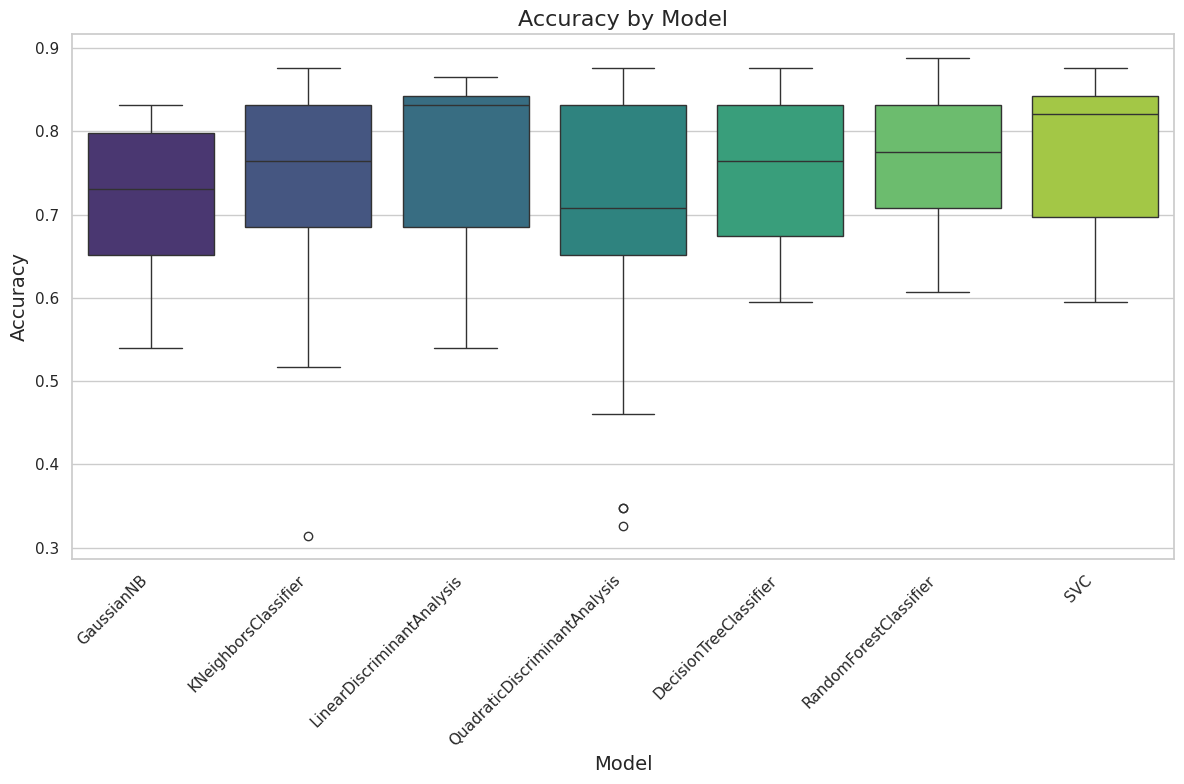

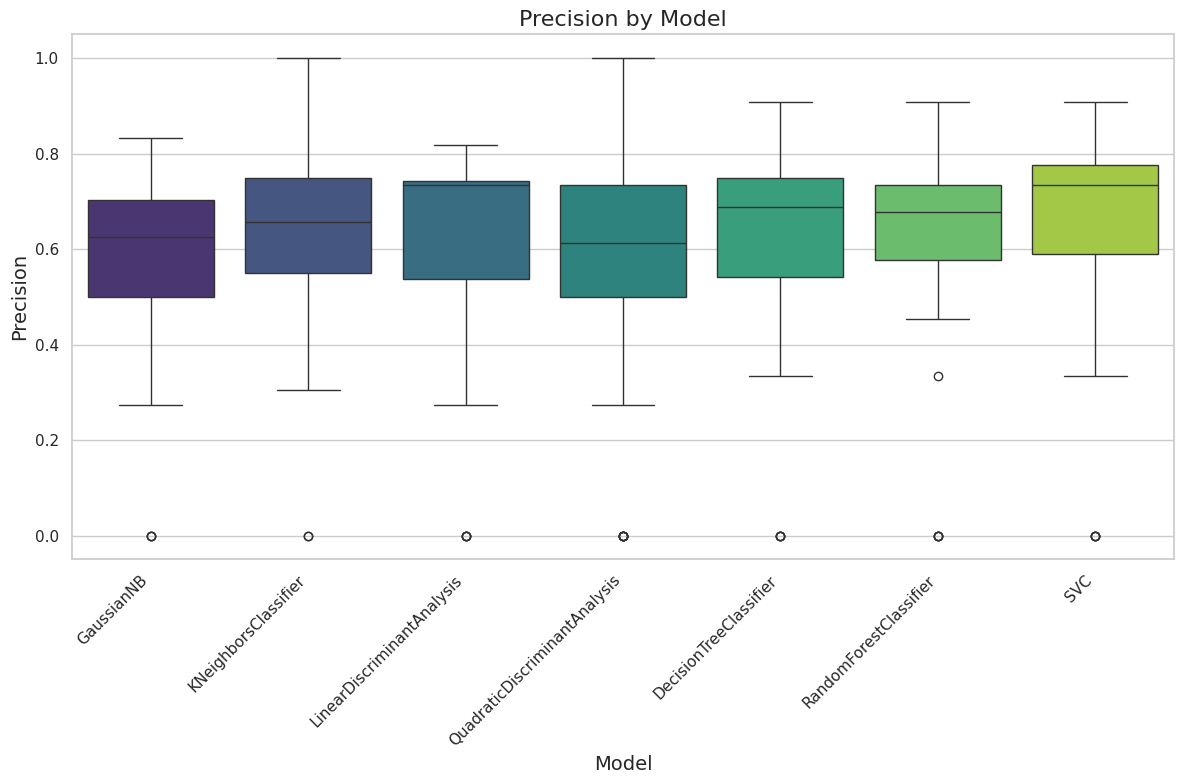

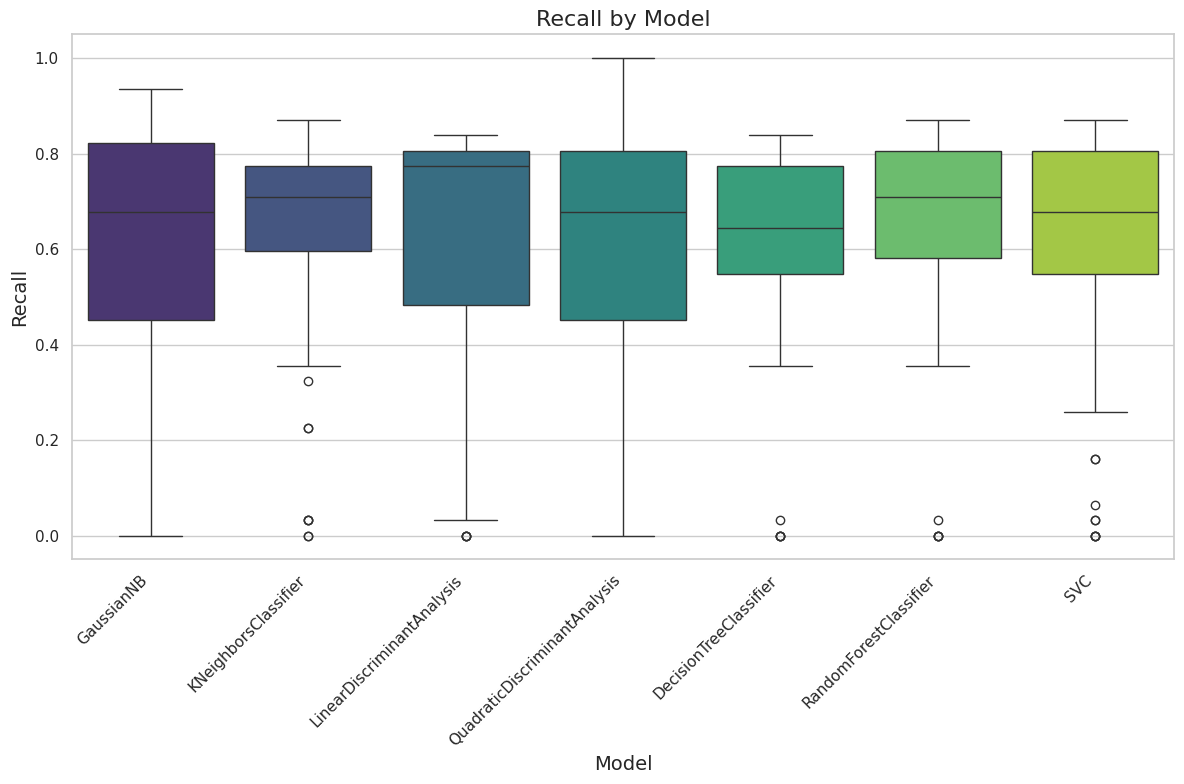

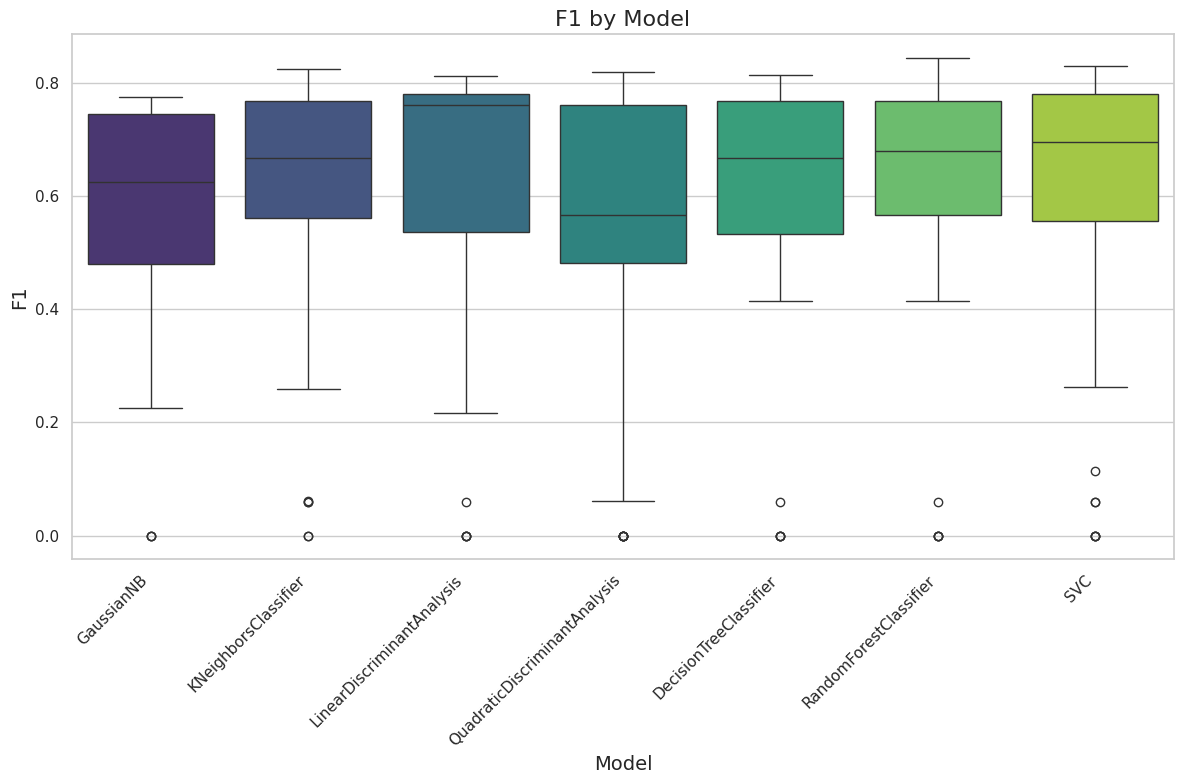

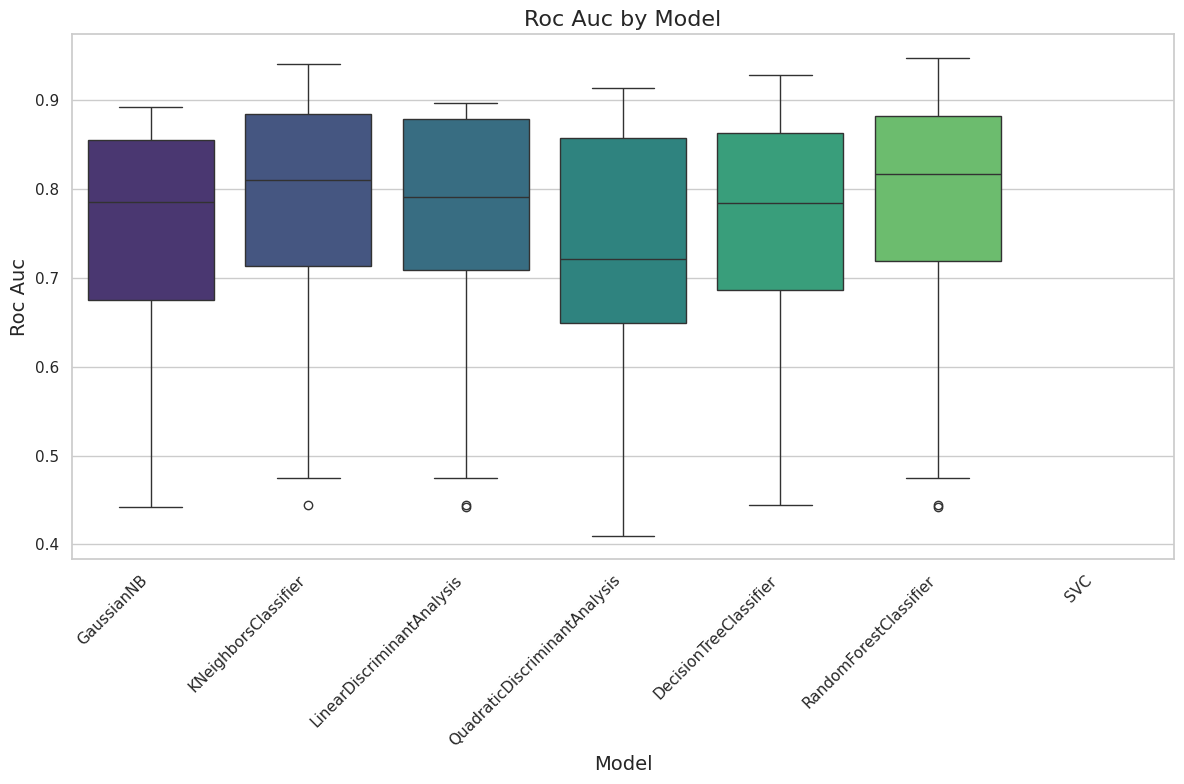

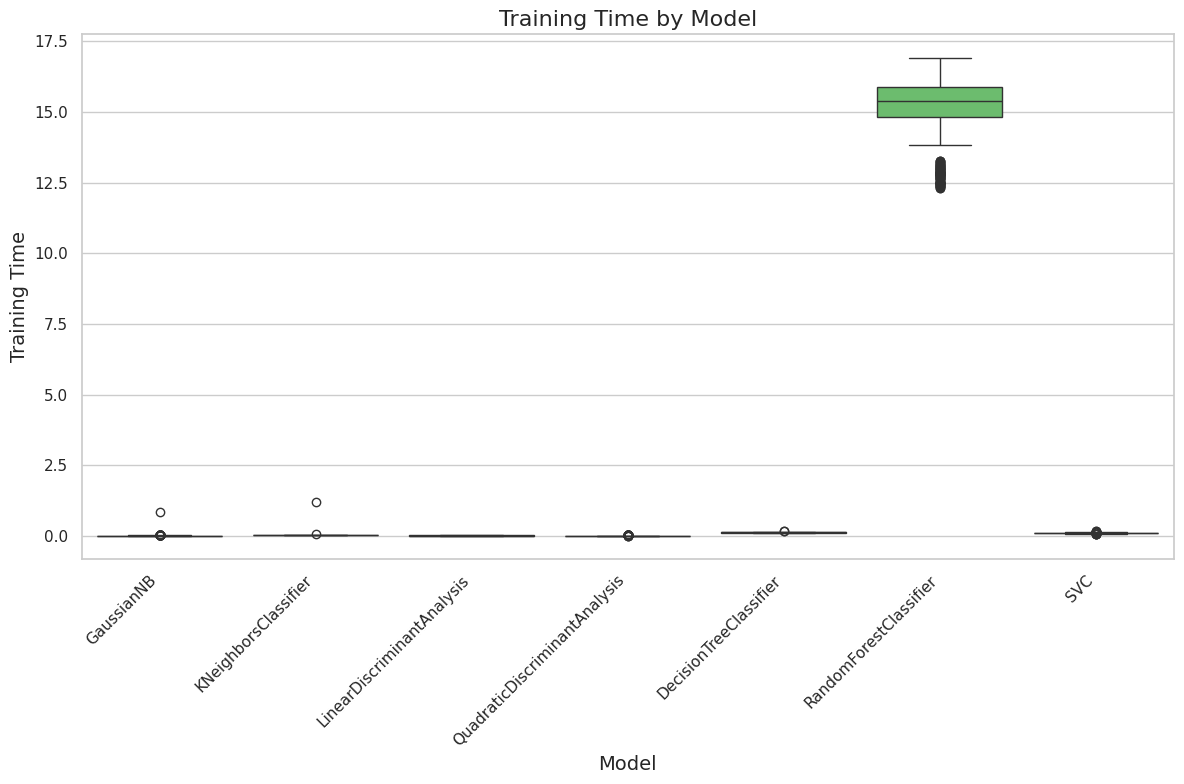

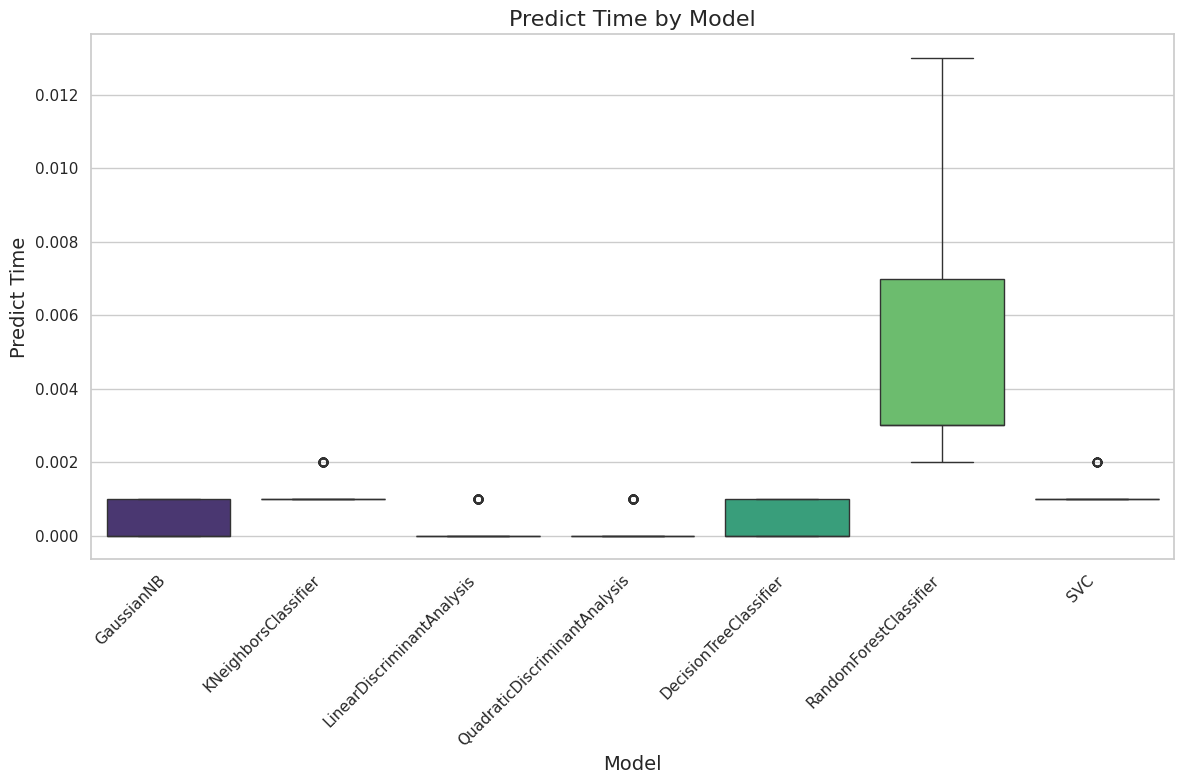

In [23]:
visualize_results(results)

## 7. Findings

Best models created for this tasks are Random Forest Classifier and K-Nearest Neighbours

As their f1-score, precision, recall, and accuracy are quite the same I decided to choose as a three final models:

* RandomForestClassifier with `max_depth`: 10, `min_samples_leaf`: 1, `min_samples_split`: 2, `n_estimators`: 100 configuration and classifying on `Sex`, `Pclass2`, `Pclass3`, `Pclass1` `Fare`, `Age`, `EmbarkedQ` columns

* Support Vector Classifier with `C`: 10 and `degree`: 2 and classifying on `Sex`, `Pclass3`, `Age`, `Fare`, `Pclass2` columns

* K-Nearest Neighbours with 5 number of neighbros and classifying on `Sex`, `Pclass2`, `Pclass3`, `Age`, `EmbarkedS`, `EmbarkedQ` columns

In [98]:
X_train, y_train = train_clean.drop(["Survived"], axis=1), train_clean["Survived"]

In [99]:
best_model_knn = KNeighborsClassifier(
    n_neighbors=5
)

In [100]:
best_model_knn.fit(X=X_train[["Sex", "Pclass2", "Pclass3", "Age", "EmbarkedS", "EmbarkedQ"]], y=y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [101]:
best_model_rfc = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
)

In [102]:
best_model_rfc.fit(X=X_train[["Sex", "Pclass2", "Pclass3", "Pclass1", "Fare", "Age", "EmbarkedQ"]], y=y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [103]:
best_model_svc = SVC(
    C=10,
    degree=2
)

In [104]:
best_model_svc.fit(X=X_train[["Sex", "Pclass2", "Pclass3", "Age", "EmbarkedQ", "EmbarkedS"]], y=y_train)

,C,10
,kernel,'rbf'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## 8. Make predictions

To make proper classification test set needs to be transformed:
* `Age` must be filled out with median value from trainig set
* `Embarked`, `Pclass` must be  codded as dummy variable
* `Sex` must be coded as 0 for female and 1 for male
* `Age` and `Fare` must be scaled with `sklearn.preprocessing.StandardScaler` from train dataset

**Results** on new and unseen data: 


In [105]:
titatnic_test = pd.read_csv("data/test.csv")

In [106]:
titatnic_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 8.1 Data preparation

In [107]:
test_clean = titatnic_test[
    ["Pclass", "Sex", "Age", "Fare", "Embarked", "SibSp", "Parch"]
]

In [108]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Age"].median()

def fill_age(row):
    if pd.isnull(row["Age"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Age"]

test_clean["Age"] = test_clean.apply(fill_age, axis=1)

/tmp/ipykernel_35003/1020817331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Age"] = test_clean.apply(fill_age, axis=1)


In [109]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Fare"].median()

def fill_age(row):
    if pd.isnull(row["Fare"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Fare"]

test_clean["Fare"] = test_clean.apply(fill_age, axis=1)

/tmp/ipykernel_35003/3619910836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Fare"] = test_clean.apply(fill_age, axis=1)


In [110]:
embarked = pd.get_dummies(
    data=test_clean["Embarked"],
    prefix="Embarked",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked

/tmp/ipykernel_35003/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/tmp/ipykernel_35003/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/tmp/ipykernel_35003/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [111]:
test_clean["Sex"] = test_clean["Sex"].map(
    lambda x: 1 if x == "male" else 0
)

/tmp/ipykernel_35003/3965721011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Sex"] = test_clean["Sex"].map(


In [112]:
pclass = pd.get_dummies(
    data=test_clean["Pclass"],
    prefix="Pclass",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["Pclass1", "Pclass2", "Pclass3"]] = pclass

In [113]:
from sklearn.preprocessing import StandardScaler

scaler_age = StandardScaler()
scaler_fare = StandardScaler()

train = pd.read_csv("data/train.csv")

scaler_age.fit(train[["Age"]])
scaler_fare.fit(train[["Fare"]])

test_clean["Age"] = scaler_age.transform(test_clean[["Age"]])
test_clean["Fare"] = scaler_fare.transform(test_clean[["Fare"]])

In [114]:
test_clean.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch',
       'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3'],
      dtype='object')

In [115]:
test_clean = test_clean[
    ['Sex', 'Age', 'Fare', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3']
]

In [116]:
test_clean.isna().sum()

Sex          0
Age          0
Fare         0
EmbarkedC    0
EmbarkedQ    0
EmbarkedS    0
Pclass1      0
Pclass2      0
Pclass3      0
dtype: int64

In [117]:
test_clean.head()

,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,1,0.330723,-0.490783,0,1,0,0,0,1
1,0,1.191823,-0.507479,0,0,1,0,0,1
2,1,2.225142,-0.453367,0,1,0,0,1,0
3,1,-0.185937,-0.474005,0,0,1,0,0,1
4,0,-0.530377,-0.401017,0,0,1,0,0,1


In [118]:
test_clean.to_csv("data/test_clean.csv", index=False)

### 8.2 Prediction

In [119]:
test_clean = pd.read_csv("data/test_clean.csv")

In [120]:
y_pred_rfc = best_model_rfc.predict(
    test_clean[["Sex", "Pclass2", "Pclass3", "Pclass1", "Fare", "Age", "EmbarkedQ"]]
)

In [121]:
y_pred_svc = best_model_svc.predict(
    test_clean[["Sex", "Pclass2", "Pclass3", "Age", "EmbarkedQ", "EmbarkedS"]]
)

In [122]:
y_pred_knn = best_model_knn.predict(
    test_clean[["Sex", "Pclass2", "Pclass3", "Age", "EmbarkedS", "EmbarkedQ"]]
)

### 8.3 Prepare submission file

In [123]:
y_pred_rfc = pd.Series(y_pred_rfc, name="Survived")
y_pred_svc = pd.Series(y_pred_svc, name="Survived")
y_pred_knn = pd.Series(y_pred_knn, name="Survived")


In [124]:
titatnic_test_rfc = pd.concat(
    [titatnic_test, y_pred_rfc],
    axis=1
)

titatnic_test_svc = pd.concat(
    [titatnic_test, y_pred_svc],
    axis=1
)

titatnic_test_knn = pd.concat(
    [titatnic_test, y_pred_knn],
    axis=1
)

In [125]:
submission_rfc = titatnic_test_rfc[["PassengerId", "Survived"]]
submission_svc = titatnic_test_svc[["PassengerId", "Survived"]]
submission_knn = titatnic_test_knn[["PassengerId", "Survived"]]


In [126]:
submission_rfc.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [127]:
submission_svc.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [128]:
submission_knn.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [129]:
submission_rfc.to_csv("data/submission_rfc.csv", index=False)
submission_svc.to_csv("data/submission_svc.csv", index=False)
submission_knn.to_csv("data/submission_knn.csv", index=False)